In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

from darts.models import NBEATSModel
from darts.models import Prophet
from darts.models import RNNModel
from darts.models import BlockRNNModel
from darts.models import RandomForest
from darts.models import ARIMA
from darts.models import AutoARIMA
from darts.models import NaiveSeasonal

In [2]:
cols = ['COMPANY_ID', 'PRODUCT_ID', 'ITEMS', 'TOTAL', 'YEAR_MONTH']
df = pd.read_csv('../data/00_original/catalog_eladiet_2_full.csv', usecols = cols, parse_dates = ['YEAR_MONTH'])
df

,COMPANY_ID,PRODUCT_ID,ITEMS,TOTAL,YEAR_MONTH
0,32388,1656,10.0,63.30,2016-02-01
1,32388,1661,10.0,58.20,2016-02-01
2,32388,1663,20.0,66.30,2016-02-01
3,32388,1667,5.0,14.55,2016-02-01
4,32388,1668,10.0,24.97,2016-02-01
...,...,...,...,...,...
619701,47583,1690,1.0,15.71,2022-05-01
619702,47583,1811,2.0,19.78,2022-05-01
619703,47583,1862,2.0,19.04,2022-05-01
619704,47583,2468,2.0,12.04,2022-05-01


## Inspección del dataframe

In [3]:
len(df['COMPANY_ID'].unique())

3207

In [4]:
len(df['PRODUCT_ID'].unique())

339

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619706 entries, 0 to 619705
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   COMPANY_ID  619706 non-null  int64         
 1   PRODUCT_ID  619706 non-null  int64         
 2   ITEMS       619706 non-null  float64       
 3   TOTAL       619706 non-null  float64       
 4   YEAR_MONTH  619706 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 23.6 MB


In [6]:
df['COMPANY_ID'].value_counts()

32886    11600
32500     8457
36767     7415
36786     6580
36029     6571
         ...  
44422        1
34039        1
36145        1
44389        1
43502        1
Name: COMPANY_ID, Length: 3207, dtype: int64

## Ejemplo: COMPANY_ID = 32886

In [7]:
df_32886 = df[df['COMPANY_ID'] == 32886]
df_32886

,COMPANY_ID,PRODUCT_ID,ITEMS,TOTAL,YEAR_MONTH
672,32886,1655,13.0,66.63,2016-02-01
673,32886,1656,10.0,71.74,2016-02-01
674,32886,1657,6.0,16.32,2016-02-01
675,32886,1658,23.0,75.85,2016-02-01
676,32886,1659,26.0,70.72,2016-02-01
...,...,...,...,...,...
619402,32886,2557,6.0,58.24,2022-05-01
619555,32886,1674,8.0,31.76,2022-05-01
619556,32886,2375,17.0,207.50,2022-05-01
619557,32886,1765,3.0,13.52,2022-05-01


In [8]:
df_group = df_32886.loc[:, ['YEAR_MONTH','TOTAL']].groupby(['YEAR_MONTH']).sum()
df_group

,TOTAL
YEAR_MONTH,
2016-02-01,25095.75
2016-03-01,25797.75
2016-04-01,26074.37
2016-05-01,28225.24
2016-06-01,26270.87
...,...
2022-01-01,81407.32
2022-02-01,80606.18
2022-03-01,99450.91


In [9]:
df_group['TOTAL_CUM'] = df_group['TOTAL'].cumsum()
df_group

,TOTAL,TOTAL_CUM
YEAR_MONTH,,
2016-02-01,25095.75,25095.75
2016-03-01,25797.75,50893.50
2016-04-01,26074.37,76967.87
2016-05-01,28225.24,105193.11
2016-06-01,26270.87,131463.98
...,...,...
2022-01-01,81407.32,4941914.23
2022-02-01,80606.18,5022520.41
2022-03-01,99450.91,5121971.32


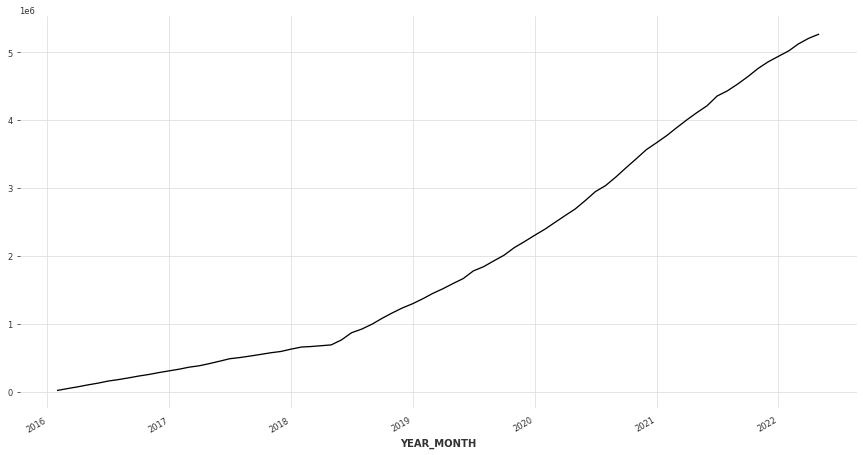

In [10]:
fig, ax = plt.subplots(figsize = (15, 8))
df_group['TOTAL_CUM'].plot();

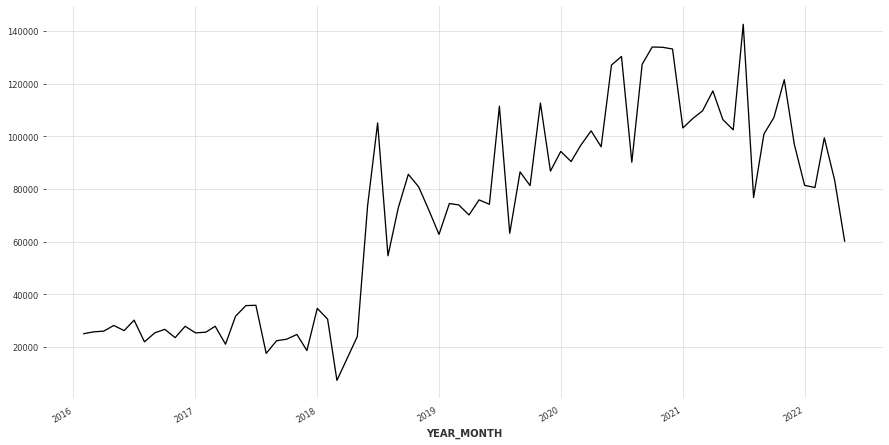

In [11]:
fig, ax = plt.subplots(figsize = (15, 8))
df_group['TOTAL'].plot();

## Creación de dataframe con el total (facturación) acumulado por mes y compañía

In [12]:
companies = df.loc[:, ['YEAR_MONTH', 'COMPANY_ID', 'TOTAL']]
companies['COMPANY_ID'] = companies['COMPANY_ID'].apply(str)
companies

,YEAR_MONTH,COMPANY_ID,TOTAL
0,2016-02-01,32388,63.30
1,2016-02-01,32388,58.20
2,2016-02-01,32388,66.30
3,2016-02-01,32388,14.55
4,2016-02-01,32388,24.97
...,...,...,...
619701,2022-05-01,47583,15.71
619702,2022-05-01,47583,19.78
619703,2022-05-01,47583,19.04
619704,2022-05-01,47583,12.04


Convertimos el dataframe a formato *wide*, tomando como índice la fecha, y cada columna es el valor de facturación de cada compañía en dicha fecha. Para ello agrupamos las facturaciones de cada compañía por mes.

In [13]:
companies_p = companies.pivot_table(values = 'TOTAL',
                                   index = 'YEAR_MONTH',
                                   columns = 'COMPANY_ID',
                                   aggfunc = np.sum)
companies_p

COMPANY_ID,14333,14335,14584,14590,14835,14836,14837,14840,14841,14842,...,47511,47523,47535,47559,47562,47565,47571,47576,47579,47583
YEAR_MONTH,,,,,,,,,,,,,,,,,,,,,
2016-02-01,NaN,NaN,NaN,124.96,NaN,1461.24,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01,NaN,259.88,NaN,NaN,NaN,2211.64,NaN,304.80,NaN,272.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-01,NaN,NaN,NaN,NaN,NaN,3366.78,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-01,NaN,421.01,NaN,160.60,NaN,765.74,NaN,201.36,NaN,104.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-01,NaN,NaN,NaN,NaN,694.83,1430.45,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,128.92,753.61,NaN,318.21,NaN,1098.95,632.58,1044.84,NaN,992.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-01,128.92,705.97,NaN,NaN,NaN,1334.98,663.39,847.24,NaN,814.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01,128.92,551.76,NaN,1155.16,NaN,895.54,449.72,906.08,NaN,1601.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Como tenemos muchas celdas vacías (*NaN*) vamos a filtrar el dataframe, quedándonos sólo con las compañías que cumplen los siguientes 2 criterios:
* Tienen al menos un valor de facturación en 36 períodos.
* Desde el 01/01/2021, tienen al menos un valor de facturación en 6 períodos.

In [14]:
sum(companies_p.count() >= 36)

1064

In [15]:
sum(companies_p[companies_p.index >= '2021-01-01'].count() >= 6)

1383

In [16]:
companies_f1 = companies_p.dropna(axis = 1, thresh = 36)
companies_f1

COMPANY_ID,14335,14584,14590,14836,14837,14840,14842,14846,15092,15093,...,43212,43272,43354,43364,43421,43555,43556,43640,43689,43747
YEAR_MONTH,,,,,,,,,,,,,,,,,,,,,
2016-02-01,NaN,NaN,124.96,1461.24,NaN,NaN,NaN,NaN,187.11,457.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01,259.88,NaN,NaN,2211.64,NaN,304.80,272.90,NaN,291.23,384.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-01,NaN,NaN,NaN,3366.78,NaN,NaN,NaN,165.66,318.20,502.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-01,421.01,NaN,160.60,765.74,NaN,201.36,104.97,NaN,NaN,163.54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-01,NaN,NaN,NaN,1430.45,NaN,NaN,NaN,172.93,265.89,593.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,753.61,NaN,318.21,1098.95,632.58,1044.84,992.02,103.08,286.95,574.19,...,631.86,156.66,674.89,500.17,4608.16,502.94,1966.92,44.94,180.92,341.76
2022-02-01,705.97,NaN,NaN,1334.98,663.39,847.24,814.42,103.08,545.97,798.90,...,884.27,283.48,386.37,500.17,6326.60,494.18,1179.52,384.84,334.16,871.56
2022-03-01,551.76,NaN,1155.16,895.54,449.72,906.08,1601.02,103.08,828.20,994.90,...,587.15,256.01,289.08,500.17,8886.89,731.24,1152.48,44.94,127.80,557.55


In [17]:
companies_f2 = companies_p.loc['2021-01-01':, :].dropna(axis = 1, thresh = 6)
companies_f2

COMPANY_ID,14333,14335,14584,14590,14836,14837,14840,14842,14846,15092,...,46952,46961,46962,46963,46968,47005,47014,47028,47046,47059
YEAR_MONTH,,,,,,,,,,,,,,,,,,,,,
2021-01-01,NaN,444.64,930.07,813.18,710.35,189.48,1474.79,651.23,397.62,258.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-01,NaN,444.64,930.07,581.86,522.88,656.96,944.72,893.14,379.52,696.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-01,254.06,444.64,930.07,1457.82,737.07,631.30,793.69,1548.38,276.44,844.52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-01,127.03,444.64,85.60,1600.52,1236.75,700.60,483.92,1102.39,276.44,428.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-01,294.89,444.64,85.60,1316.05,820.18,472.60,821.26,940.40,140.98,417.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01,127.03,NaN,85.60,1594.15,634.78,472.60,545.48,1332.11,140.98,613.19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-01,127.03,NaN,NaN,1355.62,641.85,472.60,545.48,874.26,140.98,451.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-01,127.03,NaN,NaN,1177.15,438.15,697.86,726.80,553.26,103.08,365.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-01,460.08,643.11,NaN,1479.43,1204.75,404.52,644.12,839.27,NaN,694.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


El dataframe consistirá en la intersección de los 2 anteriores, ya que debe cumplir los 2 criterios.

In [18]:
companies_final = companies_f1[companies_f1.columns.intersection(companies_f2.columns)]
companies_final

COMPANY_ID,14335,14584,14590,14836,14837,14840,14842,14846,15092,15093,...,43212,43272,43354,43364,43421,43555,43556,43640,43689,43747
YEAR_MONTH,,,,,,,,,,,,,,,,,,,,,
2016-02-01,NaN,NaN,124.96,1461.24,NaN,NaN,NaN,NaN,187.11,457.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01,259.88,NaN,NaN,2211.64,NaN,304.80,272.90,NaN,291.23,384.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-01,NaN,NaN,NaN,3366.78,NaN,NaN,NaN,165.66,318.20,502.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-01,421.01,NaN,160.60,765.74,NaN,201.36,104.97,NaN,NaN,163.54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-01,NaN,NaN,NaN,1430.45,NaN,NaN,NaN,172.93,265.89,593.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,753.61,NaN,318.21,1098.95,632.58,1044.84,992.02,103.08,286.95,574.19,...,631.86,156.66,674.89,500.17,4608.16,502.94,1966.92,44.94,180.92,341.76
2022-02-01,705.97,NaN,NaN,1334.98,663.39,847.24,814.42,103.08,545.97,798.90,...,884.27,283.48,386.37,500.17,6326.60,494.18,1179.52,384.84,334.16,871.56
2022-03-01,551.76,NaN,1155.16,895.54,449.72,906.08,1601.02,103.08,828.20,994.90,...,587.15,256.01,289.08,500.17,8886.89,731.24,1152.48,44.94,127.80,557.55


Sustituimos los *NaN* por ceros.

In [19]:
companies_final = companies_final.fillna(value = 0)
companies_final

COMPANY_ID,14335,14584,14590,14836,14837,14840,14842,14846,15092,15093,...,43212,43272,43354,43364,43421,43555,43556,43640,43689,43747
YEAR_MONTH,,,,,,,,,,,,,,,,,,,,,
2016-02-01,0.00,0.0,124.96,1461.24,0.00,0.00,0.00,0.00,187.11,457.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-03-01,259.88,0.0,0.00,2211.64,0.00,304.80,272.90,0.00,291.23,384.77,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-04-01,0.00,0.0,0.00,3366.78,0.00,0.00,0.00,165.66,318.20,502.73,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-05-01,421.01,0.0,160.60,765.74,0.00,201.36,104.97,0.00,0.00,163.54,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-06-01,0.00,0.0,0.00,1430.45,0.00,0.00,0.00,172.93,265.89,593.92,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,753.61,0.0,318.21,1098.95,632.58,1044.84,992.02,103.08,286.95,574.19,...,631.86,156.66,674.89,500.17,4608.16,502.94,1966.92,44.94,180.92,341.76
2022-02-01,705.97,0.0,0.00,1334.98,663.39,847.24,814.42,103.08,545.97,798.90,...,884.27,283.48,386.37,500.17,6326.60,494.18,1179.52,384.84,334.16,871.56
2022-03-01,551.76,0.0,1155.16,895.54,449.72,906.08,1601.02,103.08,828.20,994.90,...,587.15,256.01,289.08,500.17,8886.89,731.24,1152.48,44.94,127.80,557.55


Finalmente, obtenemos la suma acumulada de los valores de cada compañía.

In [20]:
companies_final = companies_final.cumsum(axis = 0)
companies_final

COMPANY_ID,14335,14584,14590,14836,14837,14840,14842,14846,15092,15093,...,43212,43272,43354,43364,43421,43555,43556,43640,43689,43747
YEAR_MONTH,,,,,,,,,,,,,,,,,,,,,
2016-02-01,0.00,0.0,124.96,1461.24,0.00,0.00,0.00,0.00,187.11,457.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-03-01,259.88,0.0,124.96,3672.88,0.00,304.80,272.90,0.00,478.34,842.02,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-04-01,259.88,0.0,124.96,7039.66,0.00,304.80,272.90,165.66,796.54,1344.75,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-05-01,680.89,0.0,285.56,7805.40,0.00,506.16,377.87,165.66,796.54,1508.29,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-06-01,680.89,0.0,285.56,9235.85,0.00,506.16,377.87,338.59,1062.43,2102.21,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,26156.34,55944.5,60618.55,82530.15,19362.06,39579.11,45004.95,12201.62,25893.22,38121.72,...,26316.30,7470.01,15819.23,14519.73,308992.12,12820.52,24188.35,16777.75,7969.58,16395.41
2022-02-01,26862.31,55944.5,60618.55,83865.13,20025.45,40426.35,45819.37,12304.70,26439.19,38920.62,...,27200.57,7753.49,16205.60,15019.90,315318.72,13314.70,25367.87,17162.59,8303.74,17266.97
2022-03-01,27414.07,55944.5,61773.71,84760.67,20475.17,41332.43,47420.39,12407.78,27267.39,39915.52,...,27787.72,8009.50,16494.68,15520.07,324205.61,14045.94,26520.35,17207.53,8431.54,17824.52


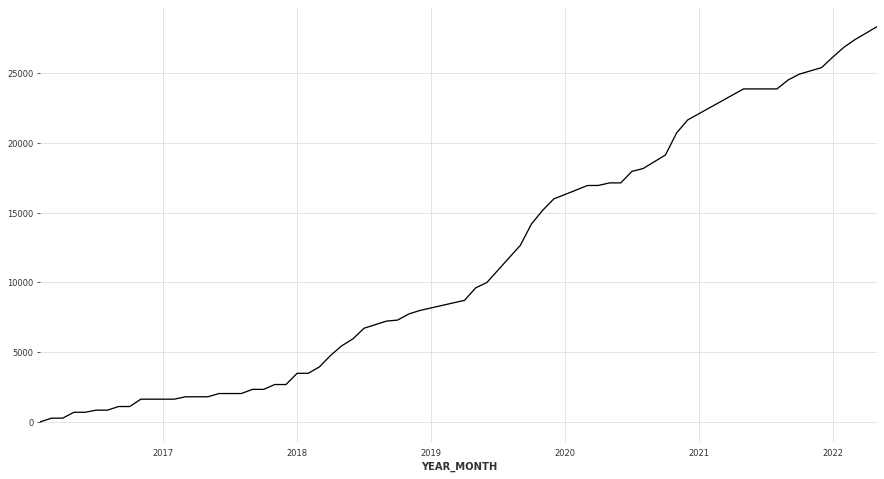

In [21]:
fig, ax = plt.subplots(figsize = (15, 8))
companies_final['14335'].plot();

In [22]:
companies_final.rename_axis('date', axis = 'index', inplace = True)
companies_final.rename_axis(None, axis = 'columns', inplace = True)
companies_final.columns = [f'y{i}' for i in range(1, len(companies_final.columns) + 1)]
companies_final

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y954,y955,y956,y957,y958,y959,y960,y961,y962,y963
date,,,,,,,,,,,,,,,,,,,,,
2016-02-01,0.00,0.0,124.96,1461.24,0.00,0.00,0.00,0.00,187.11,457.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-03-01,259.88,0.0,124.96,3672.88,0.00,304.80,272.90,0.00,478.34,842.02,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-04-01,259.88,0.0,124.96,7039.66,0.00,304.80,272.90,165.66,796.54,1344.75,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-05-01,680.89,0.0,285.56,7805.40,0.00,506.16,377.87,165.66,796.54,1508.29,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-06-01,680.89,0.0,285.56,9235.85,0.00,506.16,377.87,338.59,1062.43,2102.21,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,26156.34,55944.5,60618.55,82530.15,19362.06,39579.11,45004.95,12201.62,25893.22,38121.72,...,26316.30,7470.01,15819.23,14519.73,308992.12,12820.52,24188.35,16777.75,7969.58,16395.41
2022-02-01,26862.31,55944.5,60618.55,83865.13,20025.45,40426.35,45819.37,12304.70,26439.19,38920.62,...,27200.57,7753.49,16205.60,15019.90,315318.72,13314.70,25367.87,17162.59,8303.74,17266.97
2022-03-01,27414.07,55944.5,61773.71,84760.67,20475.17,41332.43,47420.39,12407.78,27267.39,39915.52,...,27787.72,8009.50,16494.68,15520.07,324205.61,14045.94,26520.35,17207.53,8431.54,17824.52


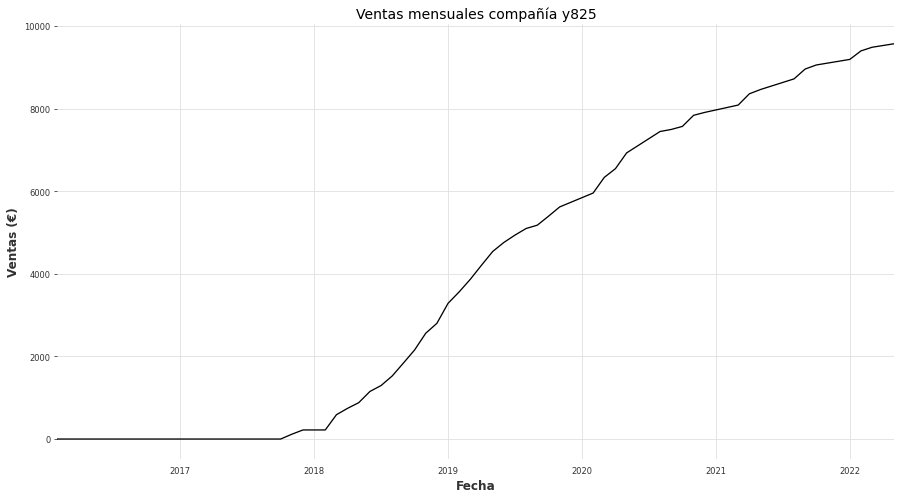

In [23]:
series_to_show = 'y825'

fig, ax = plt.subplots(figsize = (15, 8))
companies_final[series_to_show].plot()

# companies_final[:-24][series_to_show].plot(label = 'entrenamiento')
# companies_final[-24:-12][series_to_show].plot(label = 'validación')
# companies_final[-12:][series_to_show].plot(label = 'test')

ax.set_xlabel('Fecha', fontsize = 12)
ax.set_ylabel('Ventas (€)', fontsize = 12)
ax.set_title(f'Ventas mensuales compañía {series_to_show}', fontsize = 14)

#plt.legend()


plt.show();

In [24]:
len(companies_final.columns)

963

Guardamos el dataframe en un csv, que será la entrada para trabajar en Kedro.

In [25]:
#companies_final.to_csv('../data/01_raw/companies.csv')

_______________________________

## Dataframe versión reducida

Para empezar, vamos a crear un dataframe más reducido. Para ello aplicamos condiciones más estrictas a la hora de filtrar. Por ejemplo, nos quedamos sólo con las compañías que tienen algún valor de facturación en cada uno de los 76 meses para los que tenemos información.

In [26]:
sum(companies_p.count() >= 76)

25

In [27]:
companies_red_f1 = companies_p.dropna(axis = 1, thresh = 76)
# companies_red_f2 = companies_p.loc['2021-01-01':, :].dropna(axis = 1, thresh = 12)
# companies_red_final = companies_red_f1[companies_red_f1.columns.intersection(companies_red_f2.columns)]
companies_red_final = companies_red_f1.copy()
companies_red_final = companies_red_final.cumsum(axis = 0)

companies_red_final.rename_axis('date', axis = 'index', inplace = True)
companies_red_final.rename_axis(None, axis = 'columns', inplace = True)
companies_red_final.columns = [f'y{i}' for i in range(1, len(companies_red_final.columns) + 1)]

companies_red_final

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25
date,,,,,,,,,,,,,,,,,,,,,
2016-02-01,1415.50,761.90,18071.57,4556.15,827.79,213.36,1787.67,156.47,171.18,945.30,...,1016.69,491.90,2929.29,1067.31,3626.05,1874.63,1417.32,1579.17,750.69,1450.28
2016-03-01,2119.15,2328.28,33610.11,9798.60,2753.35,384.26,3708.32,2302.14,398.82,1577.86,...,2053.54,993.24,6142.14,1918.16,6735.49,6700.87,3365.11,3607.13,3255.15,1808.82
2016-04-01,2973.62,4430.28,62457.19,14963.16,4218.70,556.52,5759.61,2792.85,675.40,2238.88,...,3059.63,1626.15,9688.56,2875.87,15744.67,8496.05,4793.12,5505.51,4904.64,3249.69
2016-05-01,4496.49,5235.42,73734.24,17658.21,5641.69,815.30,8410.32,3139.72,848.66,3013.88,...,4083.01,1794.37,13875.50,3726.28,19928.42,10534.56,7689.57,6751.19,7341.18,4326.15
2016-06-01,5760.67,6939.87,98008.44,19192.45,6425.99,1024.40,10656.85,3258.36,1120.69,3524.38,...,4867.62,2292.73,18450.01,4694.87,26108.58,12101.75,8880.76,8541.26,11010.42,5236.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,165798.19,136438.06,2223626.56,1211358.02,312226.75,54700.19,183110.65,112458.76,40090.94,69054.03,...,127796.51,97212.57,574954.65,61527.69,2984516.86,1247713.65,277600.77,426414.42,337279.89,135292.15
2022-02-01,168254.18,138330.52,2244383.50,1228916.42,319398.52,55567.94,185701.88,113809.57,40632.37,69845.40,...,128949.70,100045.36,581851.24,62685.75,3014173.00,1269911.28,280707.10,432780.53,340615.50,136978.77
2022-03-01,170507.58,140898.57,2266466.87,1248454.82,326495.37,57410.37,188001.40,115425.44,41366.68,70563.46,...,130396.89,103134.97,587730.64,63536.71,3047910.02,1294058.77,283589.85,438115.87,346044.37,138959.90


In [28]:
companies_red_final.isna().sum().sum()

0

In [29]:
#companies_red_final.to_csv('../data/01_raw/companies_red.csv')

## Dataframe versión 500 series

In [30]:
sum(companies_p.count() >= 58)

508

In [31]:
sum(companies_p[companies_p.index >= '2021-01-01'].count() >= 10)

1146

In [32]:
companies_500_f1 = companies_p.dropna(axis = 1, thresh = 58)
companies_500_f2 = companies_p.loc['2021-01-01':, :].dropna(axis = 1, thresh = 10)
companies_500_final = companies_500_f1[companies_500_f1.columns.intersection(companies_500_f2.columns)]
companies_500_final

COMPANY_ID,14590,14836,14840,14842,14846,15092,15093,15094,15097,15103,...,37876,37886,37896,37898,37920,37926,37956,37975,37977,37988
YEAR_MONTH,,,,,,,,,,,,,,,,,,,,,
2016-02-01,124.96,1461.24,NaN,NaN,NaN,187.11,457.25,NaN,554.49,348.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01,NaN,2211.64,304.80,272.90,NaN,291.23,384.77,NaN,748.28,426.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-01,NaN,3366.78,NaN,NaN,165.66,318.20,502.73,203.48,961.75,546.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-01,160.60,765.74,201.36,104.97,NaN,NaN,163.54,NaN,173.69,319.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-01,NaN,1430.45,NaN,NaN,172.93,265.89,593.92,136.32,1128.32,347.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,318.21,1098.95,1044.84,992.02,103.08,286.95,574.19,NaN,375.97,5434.24,...,510.17,1318.98,391.20,1642.59,165.78,680.61,380.85,6305.83,1805.03,3655.54
2022-02-01,NaN,1334.98,847.24,814.42,103.08,545.97,798.90,NaN,1150.13,5645.09,...,606.68,1180.76,261.60,1756.13,165.78,666.48,247.98,5766.88,1837.85,4103.61
2022-03-01,1155.16,895.54,906.08,1601.02,103.08,828.20,994.90,277.38,844.75,6560.45,...,522.78,1059.19,450.48,1867.84,495.06,789.34,337.64,5558.83,2821.81,4317.24


In [33]:
companies_500_final = companies_500_final.fillna(value = 0)
companies_500_final = companies_500_final.cumsum(axis = 0)
companies_500_final

COMPANY_ID,14590,14836,14840,14842,14846,15092,15093,15094,15097,15103,...,37876,37886,37896,37898,37920,37926,37956,37975,37977,37988
YEAR_MONTH,,,,,,,,,,,,,,,,,,,,,
2016-02-01,124.96,1461.24,0.00,0.00,0.00,187.11,457.25,0.00,554.49,348.72,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-03-01,124.96,3672.88,304.80,272.90,0.00,478.34,842.02,0.00,1302.77,775.32,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-04-01,124.96,7039.66,304.80,272.90,165.66,796.54,1344.75,203.48,2264.52,1321.70,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-05-01,285.56,7805.40,506.16,377.87,165.66,796.54,1508.29,203.48,2438.21,1641.65,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-06-01,285.56,9235.85,506.16,377.87,338.59,1062.43,2102.21,339.80,3566.53,1988.81,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,60618.55,82530.15,39579.11,45004.95,12201.62,25893.22,38121.72,18925.53,192605.62,259735.46,...,22494.57,86653.77,116795.01,109123.06,26456.67,30171.09,40458.98,142107.16,119599.29,215577.40
2022-02-01,60618.55,83865.13,40426.35,45819.37,12304.70,26439.19,38920.62,18925.53,193755.75,265380.55,...,23101.25,87834.53,117056.61,110879.19,26622.45,30837.57,40706.96,147874.04,121437.14,219681.01
2022-03-01,61773.71,84760.67,41332.43,47420.39,12407.78,27267.39,39915.52,19202.91,194600.50,271941.00,...,23624.03,88893.72,117507.09,112747.03,27117.51,31626.91,41044.60,153432.87,124258.95,223998.25


In [34]:
companies_500_final.rename_axis('date', axis = 'index', inplace = True)
companies_500_final.rename_axis(None, axis = 'columns', inplace = True)
companies_500_final.columns = [f'y{i}' for i in range(1, len(companies_500_final.columns) + 1)]
companies_500_final

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y491,y492,y493,y494,y495,y496,y497,y498,y499,y500
date,,,,,,,,,,,,,,,,,,,,,
2016-02-01,124.96,1461.24,0.00,0.00,0.00,187.11,457.25,0.00,554.49,348.72,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-03-01,124.96,3672.88,304.80,272.90,0.00,478.34,842.02,0.00,1302.77,775.32,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-04-01,124.96,7039.66,304.80,272.90,165.66,796.54,1344.75,203.48,2264.52,1321.70,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-05-01,285.56,7805.40,506.16,377.87,165.66,796.54,1508.29,203.48,2438.21,1641.65,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-06-01,285.56,9235.85,506.16,377.87,338.59,1062.43,2102.21,339.80,3566.53,1988.81,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,60618.55,82530.15,39579.11,45004.95,12201.62,25893.22,38121.72,18925.53,192605.62,259735.46,...,22494.57,86653.77,116795.01,109123.06,26456.67,30171.09,40458.98,142107.16,119599.29,215577.40
2022-02-01,60618.55,83865.13,40426.35,45819.37,12304.70,26439.19,38920.62,18925.53,193755.75,265380.55,...,23101.25,87834.53,117056.61,110879.19,26622.45,30837.57,40706.96,147874.04,121437.14,219681.01
2022-03-01,61773.71,84760.67,41332.43,47420.39,12407.78,27267.39,39915.52,19202.91,194600.50,271941.00,...,23624.03,88893.72,117507.09,112747.03,27117.51,31626.91,41044.60,153432.87,124258.95,223998.25


In [35]:
#companies_500_final.to_csv('../data/01_raw/companies_500.csv')

In [36]:
# data_400 = data.iloc[:, :400]
# data_400

## Dataframe Electric Production

In [37]:
# ele = pd.read_csv('../data/00_original/Electric_Production.csv', parse_dates = ['DATE'])
# ele.columns = ['date', 'y1']
# ele.set_index('date', inplace = True)
# ele

In [38]:
#ele.to_csv('../data/01_raw/electric_production_proc.csv')

## Trabajar con objetos TimeSeries de Darts

In [41]:
# Fichero completo (datos de 1000 compañías aprox.)
data = pd.read_csv('../data/01_raw/companies.csv')

# Fichero reducido (datos de 25 compañías)
#data = pd.read_csv('../data/01_raw/companies_red.csv')

# Fichero reducido 500 (datos de 500 compañías)
#data = pd.read_csv('../data/01_raw/companies_500.csv')

series = TimeSeries.from_dataframe(data, time_col='date')
data = series.pd_dataframe()
data

component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y954,y955,y956,y957,y958,y959,y960,y961,y962,y963
date,,,,,,,,,,,,,,,,,,,,,
2016-02-01,0.00,0.0,124.96,1461.24,0.00,0.00,0.00,0.00,187.11,457.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-03-01,259.88,0.0,124.96,3672.88,0.00,304.80,272.90,0.00,478.34,842.02,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-04-01,259.88,0.0,124.96,7039.66,0.00,304.80,272.90,165.66,796.54,1344.75,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-05-01,680.89,0.0,285.56,7805.40,0.00,506.16,377.87,165.66,796.54,1508.29,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-06-01,680.89,0.0,285.56,9235.85,0.00,506.16,377.87,338.59,1062.43,2102.21,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,26156.34,55944.5,60618.55,82530.15,19362.06,39579.11,45004.95,12201.62,25893.22,38121.72,...,26316.30,7470.01,15819.23,14519.73,308992.12,12820.52,24188.35,16777.75,7969.58,16395.41
2022-02-01,26862.31,55944.5,60618.55,83865.13,20025.45,40426.35,45819.37,12304.70,26439.19,38920.62,...,27200.57,7753.49,16205.60,15019.90,315318.72,13314.70,25367.87,17162.59,8303.74,17266.97
2022-03-01,27414.07,55944.5,61773.71,84760.67,20475.17,41332.43,47420.39,12407.78,27267.39,39915.52,...,27787.72,8009.50,16494.68,15520.07,324205.61,14045.94,26520.35,17207.53,8431.54,17824.52


## Train - test

In [42]:
test_size = 0.2

test_set = int(data.shape[0]*test_size)


train = data.iloc[:-test_set]
test = data.iloc[-test_set:]

# Versión 400 series
#train = data_400.iloc[:-test_set]
#test = data_400.iloc[-test_set:]

test

component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y954,y955,y956,y957,y958,y959,y960,y961,y962,y963
date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,22981.12,55687.7,49749.07,73909.91,13813.16,32237.13,35646.03,10873.14,21563.34,31843.94,...,18933.58,4002.32,9047.70,9193.97,234469.81,9939.55,15032.63,13895.75,5486.78,11425.62
2021-04-01,23425.76,55773.3,51349.59,75146.66,14513.76,32721.05,36748.42,11149.58,21992.23,32657.14,...,19624.11,4130.62,9781.00,9771.17,245922.46,10019.53,16070.32,14218.91,5635.54,12250.73
2021-05-01,23870.40,55858.9,52665.64,75966.84,14986.36,33542.31,37688.82,11290.56,22409.30,33265.16,...,20451.92,4286.88,10512.51,10180.93,257771.96,10099.51,17163.13,14945.27,5946.50,12686.57
2021-06-01,23870.40,55944.5,54259.79,76601.62,15458.96,34087.79,39020.93,11431.54,23022.49,33692.82,...,21167.61,4507.03,11533.00,11043.00,268254.04,10713.24,17849.44,15618.97,6113.94,13122.41
2021-07-01,23870.40,55944.5,55615.41,77243.47,15931.56,34633.27,39895.19,11572.52,23473.88,34092.74,...,21979.44,4817.90,12444.64,11647.73,277670.71,10928.13,18919.75,15741.43,6281.38,13829.12
2021-08-01,23870.40,55944.5,56792.56,77681.62,16629.42,35360.07,40448.45,11675.60,23839.59,34412.55,...,22706.77,4999.57,13042.49,11988.46,281731.50,11143.02,19388.93,15863.89,6448.82,14082.47
2021-09-01,24513.51,55944.5,58271.99,78886.37,17033.94,36004.19,41287.72,11675.60,24533.82,34687.87,...,23415.69,5507.06,13803.62,12329.19,286852.34,11357.91,20057.91,16475.53,6907.50,14335.82
2021-10-01,24929.07,55944.5,59551.46,79679.52,17303.64,36889.09,42177.91,11675.60,24608.76,36183.75,...,24315.34,6043.55,14416.40,12756.21,291228.48,11849.60,20631.03,16642.93,7039.54,14987.90
2021-11-01,25165.90,55944.5,59925.90,80427.92,17710.38,37419.91,42860.53,11957.56,25319.32,36683.71,...,24893.16,6579.80,14893.02,12941.94,299589.31,12083.59,21602.85,16687.87,7526.54,15336.29


## Tendencias entrenamiento, validación y test

In [99]:
tend = pd.DataFrame(index = ['Train', 'Val', 'Test'], columns = data.columns)
tend.loc['Train', :] = (data.iloc[-25, :] - data.iloc[-36, :]) / 12
tend.loc['Val', :] = (data.iloc[-13, :] - data.iloc[-24, :]) / 12
tend.loc['Test', :] = (data.iloc[-1, :] - data.iloc[-12, :]) / 12
tend

component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y954,y955,y956,y957,y958,y959,y960,y961,y962,y963
Train,595.371667,1550.755,1615.2575,1006.1225,439.81,552.443333,823.745,230.814167,237.800833,690.208333,...,874.6325,206.669167,406.318333,343.458333,7538.309167,500.043333,474.653333,631.789167,247.541667,372.384167
Val,561.615833,1103.818333,1119.468333,723.711667,500.473333,824.7575,681.865,217.380833,493.025,617.281667,...,563.831667,97.431667,399.655,359.410833,11421.398333,114.489167,849.9775,374.53,211.51,614.3775
Test,373.495833,0.0,742.174167,783.083333,533.770833,738.143333,836.411667,98.533333,454.56,577.275,...,671.945833,335.671667,482.773333,524.049167,6022.434167,337.815,953.683333,132.38,230.756667,503.0175


In [100]:
tend_media = pd.DataFrame(np.round(tend.apply(np.mean, axis = 1), 1), columns = ['Tendencia media'])
tend_media

,Tendencia media
Train,1106.7
Val,1404.8
Test,1103.4


## Visualización predicciones serie 1000

In [44]:
naive_fc = pd.read_parquet('../data/07_model_output/naive_forecast.pq')
arima_fc = pd.read_parquet('../data/07_model_output/arima_forecast.pq')
prophet_fc = pd.read_parquet('../data/07_model_output/prophet_forecast.pq')
rnn_fc = pd.read_parquet('../data/07_model_output/rnn_forecast.pq')
nbeats_fc = pd.read_parquet('../data/07_model_output/nbeats_forecast.pq')

nbeats_fc

component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y954,y955,y956,y957,y958,y959,y960,y961,y962,y963
date,,,,,,,,,,,,,,,,,,,,,
2021-06-01,23662.787967,56409.495294,54572.178291,77303.212205,15594.648213,34734.747776,38624.191116,11571.783745,23287.503924,33761.283277,...,21322.405734,4337.231501,11082.386573,10694.367076,265086.956132,9843.618849,18174.996252,15328.428881,6272.944094,13294.391092
2021-07-01,24099.127936,56907.357343,55778.598854,78022.597038,15993.679881,35494.814749,39380.806874,11792.338371,24153.959496,34407.474626,...,21763.750378,4315.623000,11403.252125,11190.749763,273158.666165,9815.674689,19046.073586,15815.818208,6459.886299,13829.477553
2021-08-01,24206.389004,56787.782041,57685.187227,78908.805637,16509.180561,36000.660232,40203.082048,11994.534498,25105.199976,34876.360752,...,22116.279267,4350.488332,11812.102691,11584.852759,278847.427448,9773.205153,19994.216100,16593.790725,6680.497456,14232.536441
2021-09-01,24404.494986,57897.440473,59343.501943,80126.318095,16975.598901,37251.310381,41101.241464,12160.330675,25972.639125,35672.502013,...,22993.085336,4373.917358,12156.600303,12037.377422,286530.697008,10021.354978,21151.657999,17114.231567,7075.058319,14716.576974
2021-10-01,25038.989601,58456.260739,60619.692222,82590.139428,17518.764617,38052.919611,41663.722892,12348.847496,26947.090417,36605.576646,...,23771.145935,4397.025167,12658.858107,12370.307121,295017.997894,10332.066288,22123.865058,17781.108747,7335.264269,14962.388359
2021-11-01,25711.776575,59155.890063,62155.035187,84776.436055,18036.455585,39084.697923,42468.892878,12827.497634,27841.712135,37492.844936,...,24475.213012,4471.907012,13003.687349,12657.893724,305564.705127,10392.692328,23264.690409,18405.133832,7546.224526,15294.797668
2021-12-01,25881.223136,60209.147851,63536.824983,86486.230785,18418.393465,39998.870117,43192.633445,13132.508707,28393.938047,38181.206640,...,25040.850543,4539.050152,13134.457991,13149.415784,313983.114224,10280.706564,24056.389307,18955.580523,7849.795156,15670.864926
2022-01-01,26528.301880,60817.224744,64843.431014,88800.285057,18929.612884,41197.677104,44157.154120,13465.289502,29164.215166,38741.488009,...,25698.702161,4606.925024,13443.525997,13688.237447,322238.135092,10538.080002,24864.407327,19381.323084,8195.183382,16255.242284
2022-02-01,27096.253532,62046.670993,66111.820555,91258.915395,19535.992758,42456.809225,45281.634510,13676.594709,30219.649130,39327.943567,...,26119.308801,4753.357817,13759.488127,14207.708616,331754.821537,11141.342052,25708.992439,19664.093561,8506.882497,16831.274495


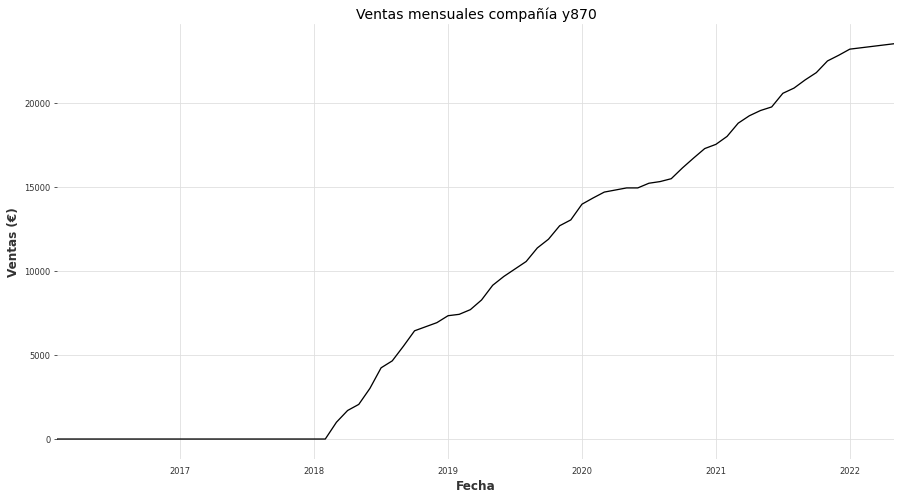

In [63]:
series_to_show = 'y870'

fig, ax = plt.subplots(figsize = (15, 8))
companies_final[series_to_show].plot()

# companies_final[:-24][series_to_show].plot(label = 'entrenamiento')
# companies_final[-24:-12][series_to_show].plot(label = 'validación')
# companies_final[-12:][series_to_show].plot(label = 'test')

ax.set_xlabel('Fecha', fontsize = 12)
ax.set_ylabel('Ventas (€)', fontsize = 12)
ax.set_title(f'Ventas mensuales compañía {series_to_show}', fontsize = 14)

#plt.legend()


plt.show();

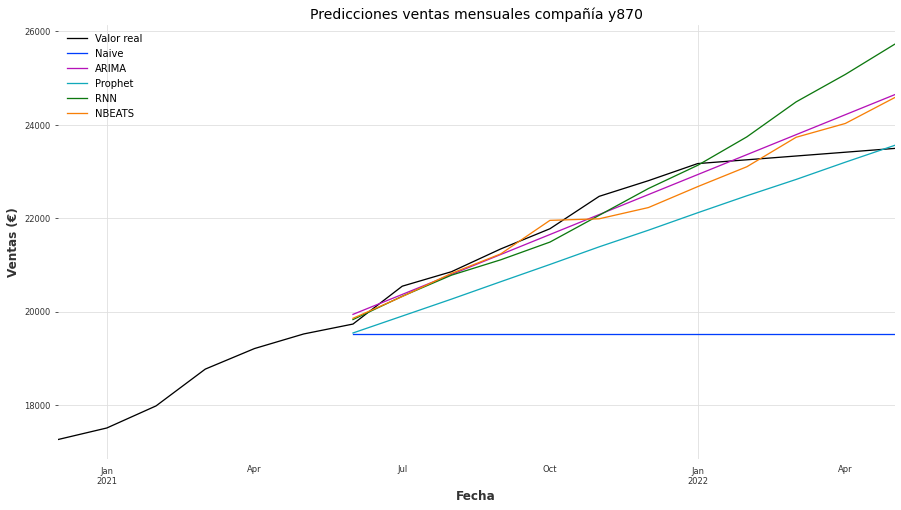

In [65]:
series_to_show = 'y870'

fig, ax = plt.subplots(figsize = (15, 8))

data[series_to_show][-18:].plot(label = 'Valor real')
#test[series_to_show].plot(label = 'true values')
naive_fc[series_to_show].plot(label = 'Naive')
arima_fc[series_to_show].plot(label = 'ARIMA')
prophet_fc[series_to_show].plot(label = 'Prophet')
rnn_fc[series_to_show].plot(label = 'RNN')
nbeats_fc[series_to_show].plot(label = 'NBEATS')

ax.set_xlabel('Fecha', fontsize = 12)
ax.set_ylabel('Ventas (€)', fontsize = 12)
ax.set_title(f'Predicciones ventas mensuales compañía {series_to_show}', fontsize = 14)

plt.legend();

________________________
_________________________

## Evaluación del modelo

### Métricas independientes de la escala

In [41]:
# MAPE = Mean Absolute Percentage Error
def _mape(y, y_hat):
    return np.mean(np.abs((y - y_hat)/y)*100)

In [42]:
def evaluate_mape(test, forecast, window_forecast = 3):
    h = len(forecast)
    w = window_forecast
    
    # Medida global
    mape_values = [_mape(test[y], forecast[y]) for y in test.columns]
    
    names = ['mape_avg', 'mape_p25', 'mape_p50', 'mape_p75', 'mape_p95', 'mape_p99']
    values = np.concatenate((np.array([np.mean(mape_values)]), np.percentile(mape_values, [25, 50, 75, 95, 99])))
    mape_global = dict(zip(names, values))
    
    # Medida por ventanas
    mape_w = {}
    period = 1
    for i in range(0, h, w):
        mape_w_values = [_mape(test[i:i+w][y], forecast[i:i+w][y]) for y in test.columns]
        mape_w[f'mape_w{period}_avg'] = np.mean(mape_w_values)
        mape_w[f'mape_w{period}_p75'] = np.percentile(mape_w_values, 75)
        period += 1

    
    return {**mape_global, **mape_w}

In [43]:
def _mae(y, y_hat):
    return np.mean(np.abs(y - y_hat))

In [64]:
naive_hat = train.iloc[:-1, :].reset_index().drop(columns = ['date'])
naive = train.iloc[1:, :].reset_index().drop(columns = ['date'])

In [65]:
naive

component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25
0,2119.15,2328.28,33610.11,9798.60,2753.35,384.26,3708.32,2302.14,398.82,1577.86,...,2053.54,993.24,6142.14,1918.16,6735.49,6700.87,3365.11,3607.13,3255.15,1808.82
1,2973.62,4430.28,62457.19,14963.16,4218.70,556.52,5759.61,2792.85,675.40,2238.88,...,3059.63,1626.15,9688.56,2875.87,15744.67,8496.05,4793.12,5505.51,4904.64,3249.69
2,4496.49,5235.42,73734.24,17658.21,5641.69,815.30,8410.32,3139.72,848.66,3013.88,...,4083.01,1794.37,13875.50,3726.28,19928.42,10534.56,7689.57,6751.19,7341.18,4326.15
3,5760.67,6939.87,98008.44,19192.45,6425.99,1024.40,10656.85,3258.36,1120.69,3524.38,...,4867.62,2292.73,18450.01,4694.87,26108.58,12101.75,8880.76,8541.26,11010.42,5236.74
4,7266.28,8081.87,116923.73,22643.15,7785.80,1211.83,13542.46,3530.93,1319.43,4492.18,...,5715.17,2768.44,26870.65,5331.31,35396.56,16331.76,11117.23,11270.40,12930.48,7255.03
5,7275.30,9201.10,117240.13,23685.40,8903.14,1405.61,14504.80,3759.81,1521.87,4887.28,...,6573.55,3158.29,29591.11,5608.17,36363.50,17853.91,11705.22,12441.42,13311.48,7818.18
6,8588.92,10226.69,135750.77,29581.13,10008.68,1575.59,16147.09,4101.70,1840.30,5632.08,...,7854.09,3742.83,32453.49,6399.71,42652.61,18926.61,13648.40,13610.46,14792.25,8832.47
7,8886.37,11400.13,156779.28,34199.82,11199.21,1940.49,18512.99,4674.78,1983.96,6157.43,...,8694.40,4281.21,35950.64,7564.88,49520.81,22488.33,15122.08,14766.66,17324.01,9832.82
8,10048.93,12361.33,172914.40,41282.32,12514.08,2179.19,20548.32,5720.91,2358.02,6964.63,...,9436.90,4820.64,44415.38,7726.86,55291.61,25104.79,17270.51,16772.25,18847.35,10996.24
9,11179.56,13344.72,184167.14,45864.10,13833.87,2345.09,22049.85,6011.39,2509.23,7604.93,...,10037.43,5416.19,45554.55,8003.10,64048.93,28965.57,18710.28,18476.07,20423.97,11762.57


In [66]:
naive_hat

component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25
0,1415.50,761.90,18071.57,4556.15,827.79,213.36,1787.67,156.47,171.18,945.30,...,1016.69,491.90,2929.29,1067.31,3626.05,1874.63,1417.32,1579.17,750.69,1450.28
1,2119.15,2328.28,33610.11,9798.60,2753.35,384.26,3708.32,2302.14,398.82,1577.86,...,2053.54,993.24,6142.14,1918.16,6735.49,6700.87,3365.11,3607.13,3255.15,1808.82
2,2973.62,4430.28,62457.19,14963.16,4218.70,556.52,5759.61,2792.85,675.40,2238.88,...,3059.63,1626.15,9688.56,2875.87,15744.67,8496.05,4793.12,5505.51,4904.64,3249.69
3,4496.49,5235.42,73734.24,17658.21,5641.69,815.30,8410.32,3139.72,848.66,3013.88,...,4083.01,1794.37,13875.50,3726.28,19928.42,10534.56,7689.57,6751.19,7341.18,4326.15
4,5760.67,6939.87,98008.44,19192.45,6425.99,1024.40,10656.85,3258.36,1120.69,3524.38,...,4867.62,2292.73,18450.01,4694.87,26108.58,12101.75,8880.76,8541.26,11010.42,5236.74
5,7266.28,8081.87,116923.73,22643.15,7785.80,1211.83,13542.46,3530.93,1319.43,4492.18,...,5715.17,2768.44,26870.65,5331.31,35396.56,16331.76,11117.23,11270.40,12930.48,7255.03
6,7275.30,9201.10,117240.13,23685.40,8903.14,1405.61,14504.80,3759.81,1521.87,4887.28,...,6573.55,3158.29,29591.11,5608.17,36363.50,17853.91,11705.22,12441.42,13311.48,7818.18
7,8588.92,10226.69,135750.77,29581.13,10008.68,1575.59,16147.09,4101.70,1840.30,5632.08,...,7854.09,3742.83,32453.49,6399.71,42652.61,18926.61,13648.40,13610.46,14792.25,8832.47
8,8886.37,11400.13,156779.28,34199.82,11199.21,1940.49,18512.99,4674.78,1983.96,6157.43,...,8694.40,4281.21,35950.64,7564.88,49520.81,22488.33,15122.08,14766.66,17324.01,9832.82
9,10048.93,12361.33,172914.40,41282.32,12514.08,2179.19,20548.32,5720.91,2358.02,6964.63,...,9436.90,4820.64,44415.38,7726.86,55291.61,25104.79,17270.51,16772.25,18847.35,10996.24


In [67]:
mae_in_sample_values = [_mae(naive[y], naive_hat[y]) for y in test.columns]
mae_in_sample_values

[2003.4133333333336,
 1960.1585000000002,
 28992.184499999996,
 15600.456166666667,
 3811.862666666667,
 668.865,
 2505.5976666666666,
 1555.4769999999999,
 560.2926666666666,
 960.7765000000003,
 4977.631833333333,
 432.60966666666684,
 970.3623333333331,
 2032.5586666666668,
 3044.761666666667,
 1756.1873333333326,
 1194.6939999999997,
 7714.509000000002,
 860.8715,
 31984.610166666665,
 15076.729499999998,
 3837.750666666667,
 5666.2725,
 4989.640333333333,
 1813.7911666666666]

## Modelo NBEATS

-----------------------
### Prueba NBEATS con series sin escalar

In [42]:
train_all = [TimeSeries.from_dataframe(train.loc[:, [f'y{i}']]) for i in range (1, len(train.columns) + 1)]

In [43]:
nbeats_model = NBEATSModel(input_chunk_length = 24,
                           output_chunk_length = 12,
                           generic_architecture = True,
                           num_stacks = 4,
                           num_blocks = 7,
                           num_layers = 4,
                           layer_widths = 64,
                           n_epochs = 100,
                           random_state = 123)

In [44]:
%%time

nbeats_model.fit(train_all)

[2022-07-15 08:47:00,230] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 650 samples.
[2022-07-15 08:47:00,230] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 650 samples.
2022-07-15 08:47:00 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 650 samples.
[2022-07-15 08:47:00,387] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-07-15 08:47:00,387] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-07-15 08:47:00 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-07-15 08:47:00 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-07-15 08:47:00 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-07-15 08:47:00 pytorch_l

Training: 0it [00:00, ?it/s]

CPU times: user 6min 6s, sys: 3.02 s, total: 6min 9s
Wall time: 2min 32s


In [45]:
%%time

nbeats_forecast = nbeats_model.predict(len(test), series = train_all)

Predicting: 21it [00:00, ?it/s]

CPU times: user 275 ms, sys: 154 µs, total: 276 ms
Wall time: 166 ms


In [46]:
%%time 
nbeats_forecast_dfs = [nbeats_forecast[i].pd_dataframe() for i in range(len(nbeats_forecast))]
nbeats_forecast = pd.concat(nbeats_forecast_dfs, axis = 1)
nbeats_forecast

CPU times: user 11.5 ms, sys: 0 ns, total: 11.5 ms
Wall time: 10.7 ms


component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25
date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,132125.687646,135861.784236,1.894277e+06,9.929587e+05,244327.935240,43915.249775,174096.445788,107358.435019,38364.464786,66289.800517,...,119947.370602,81402.545582,511812.043218,61985.435925,2.028177e+06,9.778185e+05,263702.637354,373362.051524,341139.260761,124539.994727
2021-04-01,132663.550248,133254.142264,1.952705e+06,1.046137e+06,252387.485720,45094.424506,170511.840719,105171.597055,38286.635589,65367.242911,...,118625.839637,80445.685226,516275.251444,60582.557854,2.099820e+06,1.018302e+06,258700.824525,386372.420663,338271.619342,122896.587987
2021-05-01,139044.019603,140847.269358,2.038575e+06,1.084528e+06,263129.901132,46928.569970,180336.705502,111196.722969,40121.862411,68999.139661,...,124984.959711,85001.413659,540464.624033,64182.037424,2.184926e+06,1.057286e+06,273123.725764,402506.568274,355174.073648,129958.699365
2021-06-01,149464.289310,153847.247154,2.157326e+06,1.144818e+06,279374.004232,50265.744282,197203.112353,122096.145471,44001.453675,74762.293986,...,136651.864243,92945.953327,580608.107788,70990.973082,2.339383e+06,1.128049e+06,299136.682873,430686.516939,388517.527287,139888.368476
2021-07-01,151554.204195,151335.327993,2.224205e+06,1.197742e+06,287689.098568,51618.873054,193947.552444,119417.151482,43662.372727,74011.810114,...,134628.082086,90879.996117,590309.905287,68544.798652,2.433728e+06,1.163727e+06,293947.755851,443550.616948,384289.027816,139492.295755
2021-08-01,158831.855092,160271.120421,2.318656e+06,1.241382e+06,300124.307072,53806.709800,205602.532698,126948.215239,46116.437706,78287.090903,...,142691.022078,96715.896511,619157.046139,73210.975168,2.531630e+06,1.211727e+06,311793.606185,463515.278420,406177.646237,147331.521688
2021-09-01,163132.317498,165476.715655,2.375350e+06,1.273651e+06,307548.932794,55215.728865,212443.189193,131082.040450,47359.566287,80809.255592,...,147119.204142,99855.780824,634266.596293,75720.549373,2.598032e+06,1.242144e+06,322058.491204,474135.733717,417973.481163,151888.529084
2021-10-01,169952.748703,173062.842048,2.464103e+06,1.323422e+06,320186.518832,57724.312688,222175.472609,137509.407810,50115.572707,83967.564355,...,154350.487049,104766.420614,661018.948526,80191.132599,2.727286e+06,1.297660e+06,337486.875751,496911.668401,439390.099754,157150.038247
2021-11-01,176858.764828,179558.071308,2.574255e+06,1.385777e+06,334181.144533,60375.615869,230494.686958,142438.172690,52224.845841,87097.488185,...,160308.149261,108572.277429,689136.154194,82825.167506,2.849716e+06,1.358224e+06,349845.980373,520804.001733,457069.686536,163147.423601


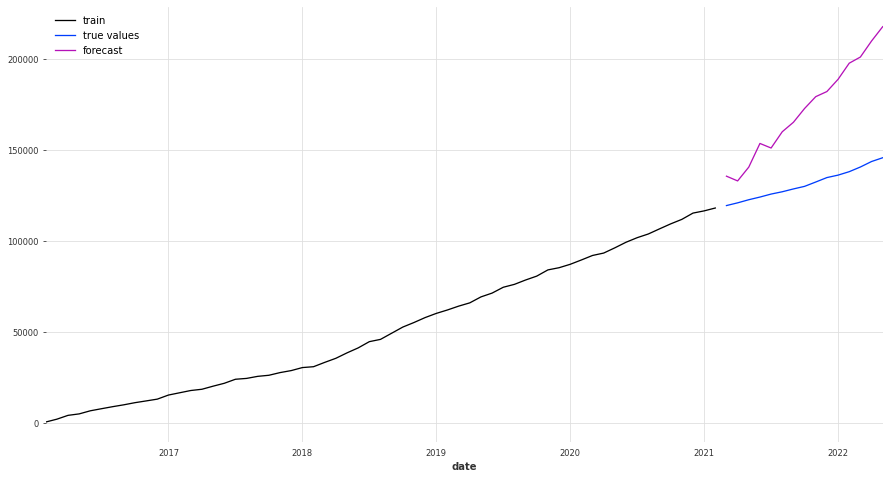

In [47]:
series_to_show = 'y2'

fig, ax = plt.subplots(figsize = (15, 8))
train[series_to_show].plot(label = 'train')
test[series_to_show].plot(label = 'true values')
nbeats_forecast[series_to_show].plot(label = 'forecast')
plt.legend();

In [48]:
mape_nbeats = evaluate_mape(test, nbeats_forecast)
mape_nbeats

{'mape_avg': 21.689959062566448,
 'mape_p25': 15.084390606752311,
 'mape_p50': 23.203131384959935,
 'mape_p75': 26.835821260741294,
 'mape_p95': 33.46631093165235,
 'mape_p99': 34.16526878466934,
 'mape_w1_avg': 8.53209902407217,
 'mape_w1_p75': 10.888972017821246,
 'mape_w2_avg': 15.976057791668852,
 'mape_w2_p75': 20.005224957231935,
 'mape_w3_avg': 21.584406969174925,
 'mape_w3_p75': 26.790365090306995,
 'mape_w4_avg': 26.940745722298924,
 'mape_w4_p75': 33.58261017142251,
 'mape_w5_avg': 35.41648580561734,
 'mape_w5_p75': 42.594158094537384}

### Prueba con series escaladas

In [49]:
%%time 

scaler = Scaler()
train_all = [TimeSeries.from_dataframe(train.loc[:, [f'y{i}']]) for i in range (1, len(train.columns) + 1)]
train_all_scaled = scaler.fit_transform(train_all)

CPU times: user 149 ms, sys: 0 ns, total: 149 ms
Wall time: 145 ms


In [50]:
nbeats_model_s = NBEATSModel(input_chunk_length = 24,
                           output_chunk_length = 12,
                           generic_architecture = True,
                           num_stacks = 4,
                           num_blocks = 7,
                           num_layers = 4,
                           layer_widths = 64,
                           n_epochs = 100,
                           random_state = 123)

In [51]:
%%time

nbeats_model_s.fit(train_all_scaled)

[2022-07-15 08:49:33,961] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 650 samples.
[2022-07-15 08:49:33,961] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 650 samples.
2022-07-15 08:49:33 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 650 samples.
[2022-07-15 08:49:33,992] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-07-15 08:49:33,992] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-07-15 08:49:33 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-07-15 08:49:33 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-07-15 08:49:33 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-07-15 08:49:33 pytorch_l

Training: 0it [00:00, ?it/s]

CPU times: user 5min 23s, sys: 2.63 s, total: 5min 26s
Wall time: 2min 14s


In [52]:
%%time

nbeats_forecast_s = nbeats_model_s.predict(len(test), series = train_all_scaled)

Predicting: 21it [00:00, ?it/s]

CPU times: user 234 ms, sys: 4.06 ms, total: 238 ms
Wall time: 142 ms


In [53]:
# scale back
nbeats_forecast_sb = scaler.inverse_transform(nbeats_forecast_s)

In [54]:
%%time 
nbeats_forecast_dfs = [nbeats_forecast_sb[i].pd_dataframe() for i in range(len(nbeats_forecast_sb))]
nbeats_forecast_sb = pd.concat(nbeats_forecast_dfs, axis = 1)
nbeats_forecast_sb

CPU times: user 11.3 ms, sys: 0 ns, total: 11.3 ms
Wall time: 10.5 ms


component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25
date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,116928.526192,117437.111405,1.684036e+06,8.770339e+05,218290.127589,38817.113455,150526.253442,92766.719569,33466.590396,57632.050874,...,104692.394723,70988.721107,451924.465136,52747.592643,1.779898e+06,8.642302e+05,228639.909741,326394.545295,297080.722847,108397.354725
2021-04-01,121676.464356,120537.294865,1.763066e+06,9.251890e+05,228730.429317,40598.703500,154632.774508,95189.785643,34615.210102,59293.624113,...,107933.320561,73090.867621,469961.016980,53946.564369,1.883287e+06,9.086940e+05,235287.173978,343228.457392,306375.992422,111691.108957
2021-05-01,121001.325855,121047.458550,1.747555e+06,9.110488e+05,226710.611215,40219.709868,155223.106797,95763.998275,34598.109831,59423.807121,...,108199.559249,73500.128347,467242.071098,54437.784962,1.854819e+06,8.974969e+05,236099.038231,339239.789877,306652.952046,111889.805755
2021-06-01,120852.851040,120816.869374,1.736010e+06,9.040353e+05,225518.493321,40135.580040,155112.528559,95598.629083,34627.717256,59208.392783,...,107958.335815,73140.003427,466660.581141,54538.819855,1.847016e+06,8.932611e+05,235796.855164,337517.493340,306373.164055,111379.792024
2021-07-01,124131.196768,123353.034083,1.791897e+06,9.404205e+05,232830.702960,41445.829367,158396.089745,97541.502111,35486.332866,60524.029546,...,110516.383570,74821.473556,479573.416224,55446.984458,1.922859e+06,9.250800e+05,240983.443083,349577.012349,313639.210552,113767.994577
2021-08-01,124297.567690,124280.498227,1.789143e+06,9.341323e+05,232558.272511,41374.368304,159609.891340,98357.195702,35641.635809,60883.703958,...,111186.683720,75384.505573,480353.343292,56099.448934,1.911232e+06,9.217809e+05,242697.035592,348528.767232,315296.788651,114452.610805
2021-09-01,128828.717960,129428.712780,1.847423e+06,9.599193e+05,240228.178626,42746.860260,166009.260738,102519.463305,37015.971632,63296.365388,...,115513.155606,78434.930292,497505.764921,58784.425106,1.968725e+06,9.503934e+05,252612.828675,359075.753955,327545.905541,118859.171692
2021-10-01,125776.428029,125115.506851,1.809744e+06,9.499764e+05,235650.769877,41895.636537,160698.375472,99093.199713,35967.120864,61327.088465,...,112080.643137,75994.967515,485070.674663,56508.289649,1.947212e+06,9.338640e+05,244654.644947,352977.836428,317793.488951,115263.187373
2021-11-01,128125.200620,126590.027220,1.853349e+06,9.785517e+05,240940.218493,42752.273499,162548.223226,100033.487900,36398.042681,62251.681290,...,113530.228920,76867.842809,494323.280988,56618.026521,1.998024e+06,9.578396e+05,247328.960587,361858.041546,321972.830460,117144.706480


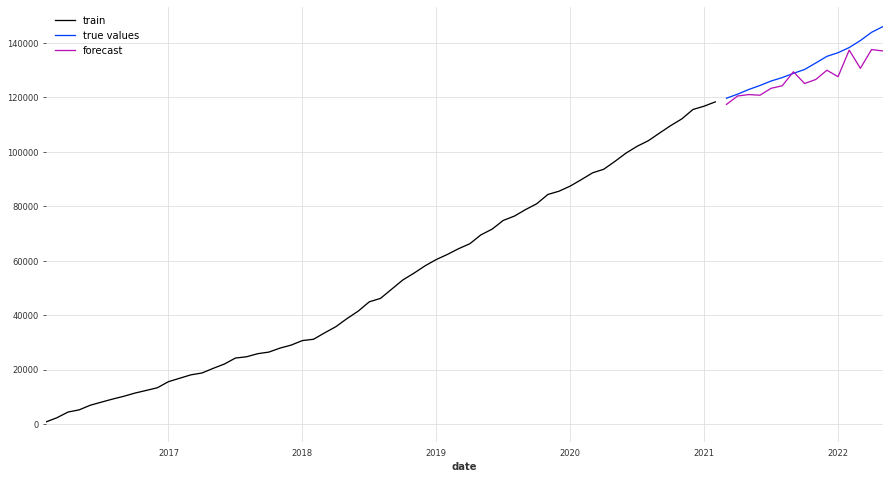

In [55]:
series_to_show = 'y2'

fig, ax = plt.subplots(figsize = (15, 8))
train[series_to_show].plot(label = 'train')
test[series_to_show].plot(label = 'true values')
nbeats_forecast_sb[series_to_show].plot(label = 'forecast')
plt.legend();

In [56]:
mape_nbeats_s = evaluate_mape(test, nbeats_forecast_sb)
mape_nbeats_s

{'mape_avg': 10.008605415198016,
 'mape_p25': 5.830198989453955,
 'mape_p50': 8.89646739096971,
 'mape_p75': 14.29621613461021,
 'mape_p95': 17.16066907818628,
 'mape_p99': 23.97792977701441,
 'mape_w1_avg': 4.763189330502621,
 'mape_w1_p75': 6.689005105725971,
 'mape_w2_avg': 8.372900958943053,
 'mape_w2_p75': 11.780158042801887,
 'mape_w3_avg': 10.692327299828134,
 'mape_w3_p75': 14.876975633677992,
 'mape_w4_avg': 12.34038078284326,
 'mape_w4_p75': 17.77580785227994,
 'mape_w5_avg': 13.874228703873012,
 'mape_w5_p75': 21.041654635522942}

### Prueba diferenciación + escalado

In [57]:
train_diff = train.diff()
train_diff.iloc[0, :] = train.iloc[0, :].copy()
train_diff

component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25
date,,,,,,,,,,,,,,,,,,,,,
2016-02-01,1415.50,761.90,18071.57,4556.15,827.79,213.36,1787.67,156.47,171.18,945.30,...,1016.69,491.90,2929.29,1067.31,3626.05,1874.63,1417.32,1579.17,750.69,1450.28
2016-03-01,703.65,1566.38,15538.54,5242.45,1925.56,170.90,1920.65,2145.67,227.64,632.56,...,1036.85,501.34,3212.85,850.85,3109.44,4826.24,1947.79,2027.96,2504.46,358.54
2016-04-01,854.47,2102.00,28847.08,5164.56,1465.35,172.26,2051.29,490.71,276.58,661.02,...,1006.09,632.91,3546.42,957.71,9009.18,1795.18,1428.01,1898.38,1649.49,1440.87
2016-05-01,1522.87,805.14,11277.05,2695.05,1422.99,258.78,2650.71,346.87,173.26,775.00,...,1023.38,168.22,4186.94,850.41,4183.75,2038.51,2896.45,1245.68,2436.54,1076.46
2016-06-01,1264.18,1704.45,24274.20,1534.24,784.30,209.10,2246.53,118.64,272.03,510.50,...,784.61,498.36,4574.51,968.59,6180.16,1567.19,1191.19,1790.07,3669.24,910.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,4386.25,2744.17,75513.67,41959.36,8868.02,1363.38,4059.19,2233.60,809.64,1847.35,...,2849.83,2178.00,12431.67,411.76,93385.67,35536.15,5859.75,13901.77,5857.53,3984.66
2020-11-01,4814.00,2471.20,69815.36,35310.72,8267.46,1330.61,4049.59,2236.32,1003.60,1458.88,...,2618.01,1849.46,19653.89,1016.20,98362.45,44477.21,6130.54,18014.33,7502.40,3923.27
2020-12-01,4446.79,3456.40,72743.34,32468.92,8083.89,1017.35,3222.86,2099.16,907.59,1597.98,...,2601.93,1863.77,21728.70,790.49,92214.31,23150.86,5177.19,12501.61,6412.66,3464.26


In [58]:
scaler = Scaler()
train_all_diff = [TimeSeries.from_dataframe(train_diff.loc[:, [f'y{i}']]) for i in range (1, len(train_diff.columns) + 1)]
train_all_diff_scaled = scaler.fit_transform(train_all_diff)

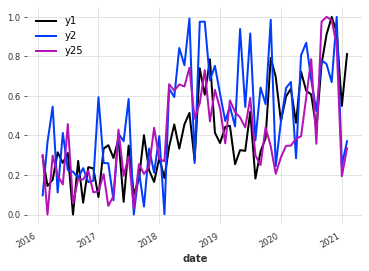

In [59]:
train_all_diff_scaled[0].plot()
train_all_diff_scaled[1].plot()
train_all_diff_scaled[24].plot();

In [60]:
nbeats_model_ds = NBEATSModel(input_chunk_length = 24,
                           output_chunk_length = 12,
                           generic_architecture = True,
                           num_stacks = 4,
                           num_blocks = 7,
                           num_layers = 4,
                           layer_widths = 64,
                           n_epochs = 100,
                           random_state = 123)

In [61]:
%%time

nbeats_model_ds.fit(train_all_diff_scaled)

[2022-07-15 08:51:49,218] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 650 samples.
[2022-07-15 08:51:49,218] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 650 samples.
2022-07-15 08:51:49 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 650 samples.
[2022-07-15 08:51:49,247] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-07-15 08:51:49,247] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-07-15 08:51:49 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-07-15 08:51:49 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-07-15 08:51:49 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-07-15 08:51:49 pytorch_l

Training: 0it [00:00, ?it/s]

CPU times: user 5min 22s, sys: 2.5 s, total: 5min 25s
Wall time: 2min 14s


In [62]:
%%time

nbeats_forecast_ds = nbeats_model_ds.predict(len(test), series = train_all_diff_scaled)

Predicting: 21it [00:00, ?it/s]

CPU times: user 220 ms, sys: 3.84 ms, total: 224 ms
Wall time: 141 ms


In [63]:
# scale back
nbeats_forecast_diff = scaler.inverse_transform(nbeats_forecast_ds)

In [64]:
%%time 
nbeats_forecast_diff_dfs = [nbeats_forecast_diff[i].pd_dataframe() for i in range(len(nbeats_forecast_diff))]
nbeats_forecast_diff = pd.concat(nbeats_forecast_diff_dfs, axis = 1)
nbeats_forecast_diff

CPU times: user 11.3 ms, sys: 0 ns, total: 11.3 ms
Wall time: 10.3 ms


component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25
date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,3197.699969,2350.193659,53199.095578,34021.347668,7127.999488,1005.662487,2947.685346,1662.353017,468.179029,1378.972494,...,2478.462566,2342.460302,13080.324617,832.832698,101345.351445,25879.137890,4818.906262,10230.202479,3955.054435,1899.691449
2021-04-01,2247.789031,1217.603990,34018.362597,32620.041933,6680.718714,1109.217989,1447.252241,2222.192647,832.514152,1081.890085,...,1278.617184,1994.600967,8712.554695,720.957005,79321.838418,22800.826398,3208.367301,5955.202737,3628.899353,1685.156389
2021-05-01,3018.008291,1549.300141,37889.089375,34265.869159,7027.904893,1105.404890,2202.018116,2007.446541,894.897919,995.376621,...,1992.650330,2039.718856,7255.321609,860.650382,84914.683867,18594.226997,4083.547752,4924.824327,4335.572419,1687.374324
2021-06-01,2396.635463,1546.240474,44403.503428,32424.976528,5906.521202,919.758794,1631.708055,2111.095071,594.422524,1159.893735,...,1952.953504,2611.688246,8975.301535,1273.553354,68471.013928,30624.621387,3570.002094,9894.325023,3537.868491,2130.256790
2021-07-01,3209.503804,2867.911375,47976.835355,43434.503037,7429.007470,1060.959790,2688.141533,2363.529351,814.169938,1166.940370,...,1476.577729,1878.971112,12659.497588,761.697290,75513.003889,27899.956918,3399.109791,6371.780000,4180.390380,2499.617707
2021-08-01,2183.761489,1810.403142,51396.811814,35990.878805,5985.891799,813.814060,1791.982396,1774.579780,1049.595063,859.405352,...,1202.885426,1645.888774,11619.710436,971.772355,59124.267381,20311.080482,2838.638578,7327.245914,3559.763303,2278.563968
2021-09-01,1846.577687,1439.923930,35422.999427,40180.805034,7115.154509,1125.901418,1470.851109,1537.910245,620.305671,802.043314,...,1542.255103,1838.020163,5155.605807,1461.688481,60438.490441,12148.085180,1572.208727,4283.735233,3097.975482,1582.514343
2021-10-01,2881.630428,1696.973392,49064.348813,40131.197926,8087.153566,1086.895678,2059.501258,2460.997402,976.710899,1143.939507,...,1626.426152,1871.232164,8645.581501,1400.898621,68205.371838,21049.911847,2868.653570,6408.412880,4707.109338,2607.412972
2021-11-01,2721.117218,2055.370067,48976.939185,39655.781924,7439.390197,1063.009591,2555.605345,2660.298114,988.556854,1130.305980,...,930.554376,1291.150807,9719.944098,636.807711,53936.467200,22529.694963,2219.584960,7245.398810,4530.786838,2570.072016


In [65]:
nbeats_forecast_db = nbeats_forecast_diff.copy()
nbeats_forecast_db.iloc[0, :] = nbeats_forecast_db.iloc[0, :] + train.iloc[-1, :]
nbeats_forecast_db = nbeats_forecast_db.cumsum(axis = 0)
nbeats_forecast_db

component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25
date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,124817.999969,120721.603659,1.810802e+06,9.746049e+05,236667.549488,41350.922487,155071.215346,95147.443017,34256.919029,59970.862494,...,108866.392566,74516.000302,478880.154617,53552.432698,2.024048e+06,9.323575e+05,236501.266262,351785.722479,304084.164435,112177.441449
2021-04-01,127065.789000,121939.207649,1.844820e+06,1.007225e+06,243348.268202,42460.140476,156518.467587,97369.635665,35089.433181,61052.752579,...,110145.009750,76510.601269,487592.709312,54273.389702,2.103370e+06,9.551584e+05,239709.633564,357740.925216,307713.063788,113862.597838
2021-05-01,130083.797291,123488.507790,1.882709e+06,1.041491e+06,250376.173096,43565.545366,158720.485703,99377.082206,35984.331100,62048.129200,...,112137.660080,78550.320126,494848.030921,55134.040085,2.188285e+06,9.737526e+05,243793.181316,362665.749543,312048.636207,115549.972162
2021-06-01,132480.432754,125034.748264,1.927113e+06,1.073916e+06,256282.694298,44485.304160,160352.193758,101488.177277,36578.753624,63208.022935,...,114090.613584,81162.008372,503823.332456,56407.593439,2.256756e+06,1.004377e+06,247363.183411,372560.074565,315586.504698,117680.228952
2021-07-01,135689.936557,127902.659639,1.975090e+06,1.117350e+06,263711.701768,45546.263950,163040.335291,103851.706628,37392.923563,64374.963306,...,115567.191313,83040.979485,516482.830044,57169.290729,2.332269e+06,1.032277e+06,250762.293201,378931.854565,319766.895077,120179.846659
2021-08-01,137873.698046,129713.062781,2.026486e+06,1.153341e+06,269697.593567,46360.078010,164832.317687,105626.286408,38442.518626,65234.368657,...,116770.076739,84686.868259,528102.540480,58141.063083,2.391393e+06,1.052588e+06,253600.931779,386259.100479,323326.658380,122458.410627
2021-09-01,139720.275733,131152.986712,2.061909e+06,1.193522e+06,276812.748076,47485.979427,166303.168795,107164.196652,39062.824297,66036.411971,...,118312.331842,86524.888422,533258.146286,59602.751565,2.451831e+06,1.064736e+06,255173.140506,390542.835713,326424.633862,124040.924969
2021-10-01,142601.906161,132849.960103,2.110974e+06,1.233653e+06,284899.901641,48572.875105,168362.670053,109625.194054,40039.535196,67180.351478,...,119938.757994,88396.120586,541903.727787,61003.650185,2.520037e+06,1.085786e+06,258041.794076,396951.248592,331131.743200,126648.337942
2021-11-01,145323.023379,134905.330170,2.159951e+06,1.273309e+06,292339.291839,49635.884696,170918.275398,112285.492168,41028.092050,68310.657458,...,120869.312370,89687.271392,551623.671885,61640.457897,2.573973e+06,1.108316e+06,260261.379036,404196.647402,335662.530038,129218.409957


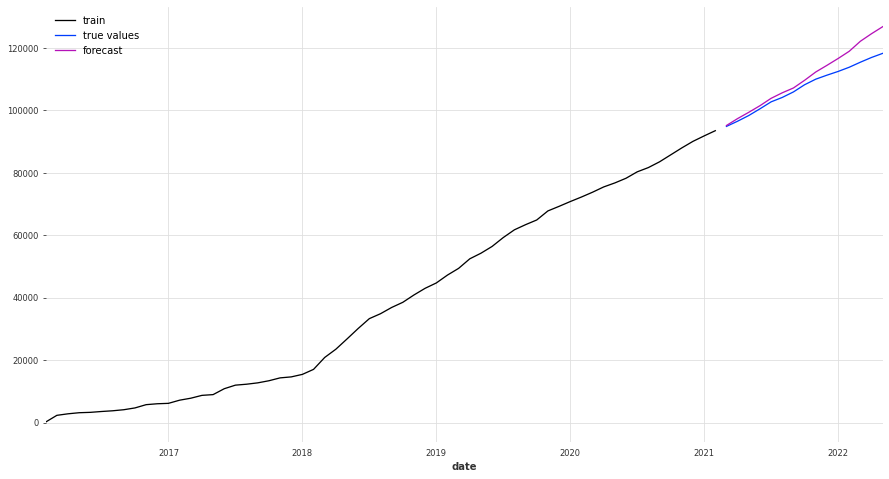

In [66]:
series_to_show = 'y8'

fig, ax = plt.subplots(figsize = (15, 8))
train[series_to_show].plot(label = 'train')
test[series_to_show].plot(label = 'true values')
nbeats_forecast_db[series_to_show].plot(label = 'forecast')
plt.legend();

In [67]:
mape_nbeats_ds = evaluate_mape(test, nbeats_forecast_db)
mape_nbeats_ds

{'mape_avg': 3.023262064045862,
 'mape_p25': 1.9099705668951557,
 'mape_p50': 2.798714785879726,
 'mape_p75': 4.0726649751797295,
 'mape_p95': 6.0826139996899515,
 'mape_p99': 7.140307663673213,
 'mape_w1_avg': 0.813902316762416,
 'mape_w1_p75': 1.0160929742432445,
 'mape_w2_avg': 1.95422058260205,
 'mape_w2_p75': 2.322771865469897,
 'mape_w3_avg': 3.2141777156230336,
 'mape_w3_p75': 4.061474640963706,
 'mape_w4_avg': 4.201713682562906,
 'mape_w4_p75': 5.880875209467406,
 'mape_w5_avg': 4.932296022678903,
 'mape_w5_p75': 6.683205296528438}

In [53]:
# Serie diferenciada + escalada - 25 series - 24/12/2/5/4/64/100
# mape_nbeats = evaluate_mape(test, nbeats_forecast)
# mape_nbeats

{'mape_avg': 3.7149481495128707,
 'mape_p25': 1.7787757733028957,
 'mape_p50': 3.218250132041844,
 'mape_p75': 5.086968435421189,
 'mape_p95': 8.002138131642647,
 'mape_p99': 8.279476691691421,
 'mape_w1_avg': 0.8343656121650591,
 'mape_w1_p75': 1.142398082946228,
 'mape_w2_avg': 2.1502117224995114,
 'mape_w2_p75': 2.5547789297115373,
 'mape_w3_avg': 3.7455545273989617,
 'mape_w3_p75': 4.499365986590907,
 'mape_w4_avg': 5.085710220003281,
 'mape_w4_p75': 7.643592572092696,
 'mape_w5_avg': 6.758898665497542,
 'mape_w5_p75': 9.320826565296779}

In [61]:
# Serie diferenciada + escalada - 25 series - 24/12/3/5/4/64/100
# mape_nbeats = evaluate_mape(test, nbeats_forecast)
# mape_nbeats

{'mape_avg': 3.381605238827715,
 'mape_p25': 1.5875713618127258,
 'mape_p50': 3.199151831693785,
 'mape_p75': 4.73866603881605,
 'mape_p95': 7.497359475545273,
 'mape_p99': 8.590141043118804,
 'mape_w1_avg': 0.9056300063534276,
 'mape_w1_p75': 1.0482651066347852,
 'mape_w2_avg': 2.2850169752476175,
 'mape_w2_p75': 3.39052157728373,
 'mape_w3_avg': 3.4628687094332564,
 'mape_w3_p75': 4.909787968098676,
 'mape_w4_avg': 4.540446068612207,
 'mape_w4_p75': 6.209706220685502,
 'mape_w5_avg': 5.714064434492064,
 'mape_w5_p75': 7.3167403771358765}

In [69]:
# Serie diferenciada + escalada - 25 series - 24/12/4/5/4/64/100
# mape_nbeats = evaluate_mape(test, nbeats_forecast)
# mape_nbeats

{'mape_avg': 3.319423559244238,
 'mape_p25': 1.7915381310812661,
 'mape_p50': 2.8618750139500935,
 'mape_p75': 4.665981112631044,
 'mape_p95': 7.808266099265421,
 'mape_p99': 8.84942226622984,
 'mape_w1_avg': 0.8560319333297692,
 'mape_w1_p75': 1.2236675822976044,
 'mape_w2_avg': 2.2178620187162874,
 'mape_w2_p75': 2.6598256858430345,
 'mape_w3_avg': 3.3224546650358895,
 'mape_w3_p75': 5.920605021341667,
 'mape_w4_avg': 4.528279176033902,
 'mape_w4_p75': 6.091296343330614,
 'mape_w5_avg': 5.672490003105341,
 'mape_w5_p75': 7.328972930715685}

In [77]:
# Serie diferenciada + escalada - 25 series - 24/12/5/5/4/64/100
# mape_nbeats = evaluate_mape(test, nbeats_forecast)
# mape_nbeats

{'mape_avg': 3.410440746445114,
 'mape_p25': 1.8950209102632545,
 'mape_p50': 2.9682326642837764,
 'mape_p75': 3.8182488672217256,
 'mape_p95': 8.190969249649832,
 'mape_p99': 8.642643518184869,
 'mape_w1_avg': 0.9446334133090462,
 'mape_w1_p75': 1.1730466258168297,
 'mape_w2_avg': 2.1920317207092626,
 'mape_w2_p75': 2.7318073069042614,
 'mape_w3_avg': 3.4875048848867793,
 'mape_w3_p75': 4.65143021883489,
 'mape_w4_avg': 4.678143675756092,
 'mape_w4_p75': 5.475923023689482,
 'mape_w5_avg': 5.749890037564388,
 'mape_w5_p75': 7.720689878894439}

In [85]:
# Serie diferenciada + escalada - 25 series - 24/12/6/5/4/64/100
# mape_nbeats = evaluate_mape(test, nbeats_forecast)
# mape_nbeats

{'mape_avg': 3.596278549744524,
 'mape_p25': 1.7454749695018685,
 'mape_p50': 3.064008939670092,
 'mape_p75': 5.024301293629128,
 'mape_p95': 7.8581348349180615,
 'mape_p99': 8.837878143449409,
 'mape_w1_avg': 1.0034199801668544,
 'mape_w1_p75': 1.6005651715533442,
 'mape_w2_avg': 2.5528002856046714,
 'mape_w2_p75': 4.0768414801842,
 'mape_w3_avg': 3.8048221261539252,
 'mape_w3_p75': 6.370165209576389,
 'mape_w4_avg': 4.775391483810798,
 'mape_w4_p75': 7.9836600680632435,
 'mape_w5_avg': 5.8449588729863695,
 'mape_w5_p75': 7.436612944665245}

In [93]:
# Serie diferenciada + escalada - 25 series - 24/12/4/6/4/64/100
# mape_nbeats = evaluate_mape(test, nbeats_forecast)
# mape_nbeats

{'mape_avg': 3.3403942619252405,
 'mape_p25': 1.2953438072420302,
 'mape_p50': 2.9791380446604205,
 'mape_p75': 4.5863112356169005,
 'mape_p95': 7.282070274544602,
 'mape_p99': 7.598724590257904,
 'mape_w1_avg': 0.8717073961333537,
 'mape_w1_p75': 1.3190599616954863,
 'mape_w2_avg': 2.062258722262079,
 'mape_w2_p75': 2.5404962418018493,
 'mape_w3_avg': 3.336236923709791,
 'mape_w3_p75': 4.982726363550603,
 'mape_w4_avg': 4.612345885285434,
 'mape_w4_p75': 6.18520310811873,
 'mape_w5_avg': 5.819422382235542,
 'mape_w5_p75': 7.698270313550214}

In [101]:
# Serie diferenciada + escalada - 25 series - 24/12/4/7/4/64/100
# mape_nbeats = evaluate_mape(test, nbeats_forecast)
# mape_nbeats

{'mape_avg': 3.023262064045862,
 'mape_p25': 1.9099705668951557,
 'mape_p50': 2.798714785879726,
 'mape_p75': 4.0726649751797295,
 'mape_p95': 6.0826139996899515,
 'mape_p99': 7.140307663673213,
 'mape_w1_avg': 0.813902316762416,
 'mape_w1_p75': 1.0160929742432445,
 'mape_w2_avg': 1.95422058260205,
 'mape_w2_p75': 2.322771865469897,
 'mape_w3_avg': 3.2141777156230336,
 'mape_w3_p75': 4.061474640963706,
 'mape_w4_avg': 4.201713682562906,
 'mape_w4_p75': 5.880875209467406,
 'mape_w5_avg': 4.932296022678903,
 'mape_w5_p75': 6.683205296528438}

### NO --- Predicción mediante un modelo por cada serie

Si utilizamos un modelo por cada serie aplicaremos el algoritmo tantas veces como número de series tenemos. Por otro lado, de esta manera, no necesitamos escalar los valores de entrenamiento.

____________________________

## Modelo RNN

### Prueba con series escaladas

In [68]:
scaler = Scaler()
train_all = [TimeSeries.from_dataframe(train.loc[:, [f'y{i}']]) for i in range (1, len(train.columns) + 1)]
train_all_scaled = scaler.fit_transform(train_all)

In [69]:
rnn_model = RNNModel(input_chunk_length = 12,
                     model = 'RNN',
                     hidden_dim = 25,
                     n_rnn_layers = 6,
                     n_epochs = 100,
                     random_state = 123)

In [70]:
%%time

rnn_model.fit(train_all_scaled)

[2022-07-15 08:54:04,459] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 925 samples.
[2022-07-15 08:54:04,459] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 925 samples.
2022-07-15 08:54:04 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 925 samples.
[2022-07-15 08:54:04,467] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-07-15 08:54:04,467] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-07-15 08:54:04 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-07-15 08:54:04 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-07-15 08:54:04 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-07-15 08:54:04 pytorch_l

Training: 0it [00:00, ?it/s]

CPU times: user 4min, sys: 2.48 s, total: 4min 2s
Wall time: 1min 33s


In [71]:
%%time

rnn_forecast = rnn_model.predict(len(test), series = train_all_scaled)
rnn_forecast

Predicting: 29it [00:00, ?it/s]

CPU times: user 111 ms, sys: 63 µs, total: 111 ms
Wall time: 94.7 ms


[<TimeSeries (DataArray) (date: 15, component: 1, sample: 1)>
 array([[[0.99868425]],
 
        [[1.00151414]],
 
        [[1.00694618]],
 
        [[1.01016194]],
 
        [[1.01229978]],
 
        [[1.0148779 ]],
 
        [[1.01683219]],
 
        [[1.01860235]],
 
        [[1.0199306 ]],
 
        [[1.02100782]],
 
        [[1.0219312 ]],
 
        [[1.0226257 ]],
 
        [[1.02319607]],
 
        [[1.02366581]],
 
        [[1.02403585]]])
 Coordinates:
   * date       (date) datetime64[ns] 2021-03-01 2021-04-01 ... 2022-05-01
   * component  (component) object 'y1'
 Dimensions without coordinates: sample,
 <TimeSeries (DataArray) (date: 15, component: 1, sample: 1)>
 array([[[1.00352333]],
 
        [[1.00661047]],
 
        [[1.0102686 ]],
 
        [[1.01312312]],
 
        [[1.01513206]],
 
        [[1.0172224 ]],
 
        [[1.01875347]],
 
        [[1.02009859]],
 
        [[1.02117479]],
 
        [[1.02200872]],
 
        [[1.02271812]],
 
        [[1.02326998]],
 
     

In [72]:
# scale back
rnn_forecast = scaler.inverse_transform(rnn_forecast)

In [73]:
%%time 
rnn_forecast_dfs = [rnn_forecast[i].pd_dataframe() for i in range(len(rnn_forecast))]
rnn_forecast = pd.concat(rnn_forecast_dfs, axis = 1)
rnn_forecast

CPU times: user 6.98 ms, sys: 4.02 ms, total: 11 ms
Wall time: 10.4 ms


component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25
date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,121462.140491,118785.786851,1.756982e+06,935775.001805,228502.441574,40288.782909,152474.293637,93642.448043,33879.878420,58712.892999,...,106333.077472,72014.584532,466852.845630,52881.714127,1.907290e+06,905335.733533,231888.399155,341388.415915,300797.604530,110652.194829
2021-04-01,121802.306743,119148.864660,1.762456e+06,938822.602684,229231.469592,40428.187048,152947.728081,93958.324482,33998.478250,58909.805972,...,106640.056050,72237.567063,468238.357214,53068.882894,1.913485e+06,908174.448115,232650.187743,342482.799723,301699.720358,110933.767880
2021-05-01,122455.264307,119579.094624,1.770834e+06,945243.737224,230760.114980,40645.097343,153566.725700,94362.016446,34125.225062,59142.843562,...,107204.853264,72664.490041,470026.479602,53269.264970,1.928514e+06,912973.019054,233720.854183,344108.581410,302979.879470,111330.947984
2021-06-01,122841.813625,119914.813396,1.776119e+06,948431.777217,231530.355408,40768.402414,154005.360654,94634.363083,34216.704535,59306.371729,...,107551.091414,72904.197016,471310.372842,53410.142782,1.935101e+06,915771.965503,234411.115783,345114.050559,303874.724134,111651.009738
2021-07-01,123098.792069,120151.083916,1.779813e+06,950489.154236,232021.399219,40854.882912,154319.357268,94827.586973,34286.064644,59425.011802,...,107771.854803,73054.332431,472272.718830,53514.892482,1.939282e+06,917798.794483,234893.105885,345870.734322,304497.707081,111878.442457
2021-08-01,123408.695308,120396.927969,1.784181e+06,953186.653749,232666.380246,40954.661881,154642.798336,95031.220564,34356.968346,59551.593340,...,108026.466198,73236.908157,473343.122630,53616.505929,1.945393e+06,920063.199314,235412.830561,346717.760795,305144.965393,112114.730083
2021-09-01,123643.610278,120576.995914,1.787480e+06,955282.552202,233167.365175,41032.568402,154889.390110,95187.610791,34411.385413,59647.737729,...,108219.658506,73378.455271,474121.113109,53695.778413,1.950249e+06,921848.326071,235813.689589,347373.995849,305630.177287,112288.219111
2021-10-01,123856.391267,120735.194812,1.790409e+06,957150.598683,233617.131428,41100.157366,155102.840869,95322.899447,34457.972658,59729.923301,...,108393.612045,73505.256137,474824.134203,53763.381324,1.954644e+06,923410.881075,236163.119475,347951.617141,306059.276178,112442.346604
2021-11-01,124016.053557,120861.766106,1.792663e+06,958529.338788,233948.744617,41151.704009,155270.466314,95428.806884,34495.166378,59795.386774,...,108524.469433,73599.542259,475378.285843,53817.028442,1.957816e+06,924588.929040,236433.112422,348393.888700,306393.160337,112563.925820


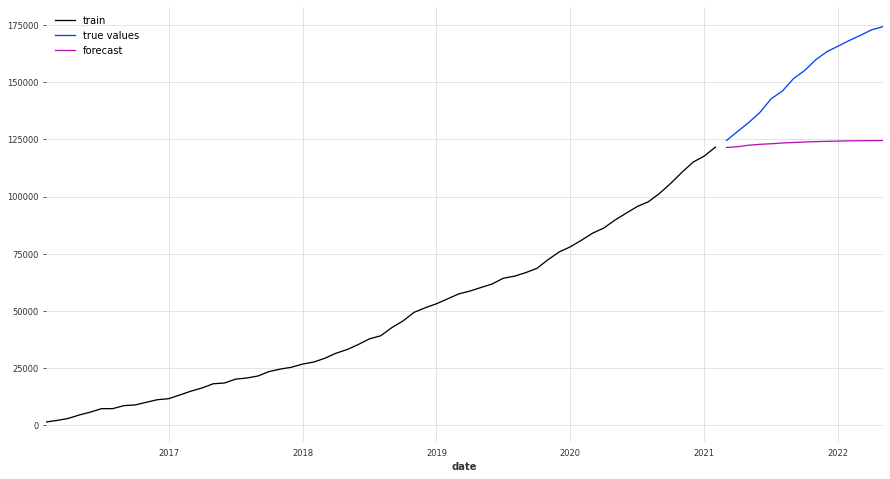

In [74]:
series_to_show = 'y1'

fig, ax = plt.subplots(figsize = (15, 8))
train[series_to_show].plot(label = 'train')
test[series_to_show].plot(label = 'true values')
rnn_forecast[series_to_show].plot(label = 'forecast')
plt.legend();

In [75]:
mape_rnn = evaluate_mape(test, rnn_forecast)
mape_rnn

{'mape_avg': 13.550754618585454,
 'mape_p25': 10.751561963080409,
 'mape_p50': 12.321125910242285,
 'mape_p75': 16.156210996397625,
 'mape_p95': 19.06664719791827,
 'mape_p99': 24.691974756197585,
 'mape_w1_avg': 4.1082705533867,
 'mape_w1_p75': 5.357122175069009,
 'mape_w2_avg': 9.322245459379797,
 'mape_w2_p75': 12.046814398339118,
 'mape_w3_avg': 14.108854442151715,
 'mape_w3_p75': 17.186895325345446,
 'mape_w4_avg': 18.4157851527896,
 'mape_w4_p75': 22.352603278810065,
 'mape_w5_avg': 21.798617485219452,
 'mape_w5_p75': 27.870899850876807}

### Prueba diferenciación + escalado

In [76]:
train_diff = train.diff()
train_diff.iloc[0, :] = train.iloc[0, :].copy()
train_diff

component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25
date,,,,,,,,,,,,,,,,,,,,,
2016-02-01,1415.50,761.90,18071.57,4556.15,827.79,213.36,1787.67,156.47,171.18,945.30,...,1016.69,491.90,2929.29,1067.31,3626.05,1874.63,1417.32,1579.17,750.69,1450.28
2016-03-01,703.65,1566.38,15538.54,5242.45,1925.56,170.90,1920.65,2145.67,227.64,632.56,...,1036.85,501.34,3212.85,850.85,3109.44,4826.24,1947.79,2027.96,2504.46,358.54
2016-04-01,854.47,2102.00,28847.08,5164.56,1465.35,172.26,2051.29,490.71,276.58,661.02,...,1006.09,632.91,3546.42,957.71,9009.18,1795.18,1428.01,1898.38,1649.49,1440.87
2016-05-01,1522.87,805.14,11277.05,2695.05,1422.99,258.78,2650.71,346.87,173.26,775.00,...,1023.38,168.22,4186.94,850.41,4183.75,2038.51,2896.45,1245.68,2436.54,1076.46
2016-06-01,1264.18,1704.45,24274.20,1534.24,784.30,209.10,2246.53,118.64,272.03,510.50,...,784.61,498.36,4574.51,968.59,6180.16,1567.19,1191.19,1790.07,3669.24,910.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,4386.25,2744.17,75513.67,41959.36,8868.02,1363.38,4059.19,2233.60,809.64,1847.35,...,2849.83,2178.00,12431.67,411.76,93385.67,35536.15,5859.75,13901.77,5857.53,3984.66
2020-11-01,4814.00,2471.20,69815.36,35310.72,8267.46,1330.61,4049.59,2236.32,1003.60,1458.88,...,2618.01,1849.46,19653.89,1016.20,98362.45,44477.21,6130.54,18014.33,7502.40,3923.27
2020-12-01,4446.79,3456.40,72743.34,32468.92,8083.89,1017.35,3222.86,2099.16,907.59,1597.98,...,2601.93,1863.77,21728.70,790.49,92214.31,23150.86,5177.19,12501.61,6412.66,3464.26


In [77]:
scaler = Scaler()
train_all_diff = [TimeSeries.from_dataframe(train_diff.loc[:, [f'y{i}']]) for i in range (1, len(train_diff.columns) + 1)]
train_all_diff_scaled = scaler.fit_transform(train_all_diff)

In [78]:
rnn_model_ds = RNNModel(input_chunk_length = 12,
                     model = 'RNN',
                     hidden_dim = 25,
                     n_rnn_layers = 6,
                     n_epochs = 100,
                     random_state = 123)

In [79]:
%%time

rnn_model_ds.fit(train_all_diff_scaled)

[2022-07-15 08:55:38,537] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 925 samples.
[2022-07-15 08:55:38,537] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 925 samples.
2022-07-15 08:55:38 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 925 samples.
[2022-07-15 08:55:38,541] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-07-15 08:55:38,541] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-07-15 08:55:38 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-07-15 08:55:38 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-07-15 08:55:38 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-07-15 08:55:38 pytorch_l

Training: 0it [00:00, ?it/s]

CPU times: user 4min 30s, sys: 2.52 s, total: 4min 33s
Wall time: 1min 49s


In [80]:
%%time

rnn_forecast_ds = rnn_model_ds.predict(len(test), series = train_all_diff_scaled)

Predicting: 29it [00:00, ?it/s]

CPU times: user 139 ms, sys: 108 µs, total: 139 ms
Wall time: 114 ms


In [81]:
# scale back
rnn_forecast_diff = scaler.inverse_transform(rnn_forecast_ds)

In [82]:
%%time 
rnn_forecast_diff_dfs = [rnn_forecast_diff[i].pd_dataframe() for i in range(len(rnn_forecast_diff))]
rnn_forecast_diff = pd.concat(rnn_forecast_diff_dfs, axis = 1)

rnn_forecast_db = rnn_forecast_diff.copy()
rnn_forecast_db.iloc[0, :] = rnn_forecast_db.iloc[0, :] + train.iloc[-1, :]
rnn_forecast_db = rnn_forecast_db.cumsum(axis = 0)
rnn_forecast_db

CPU times: user 13.8 ms, sys: 18 µs, total: 13.8 ms
Wall time: 13 ms


component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25
date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,125425.063058,120654.281554,1.817449e+06,9.674477e+05,238213.830646,41298.587825,154641.223569,95278.927960,34513.946571,59868.179973,...,109222.374907,74116.891199,478165.747613,53497.870388,2.035190e+06,9.342054e+05,237677.202373,351914.572989,304831.041415,112452.876511
2021-04-01,127688.381033,122177.819232,1.863226e+06,9.982466e+05,245124.540572,42332.734716,156629.975583,96942.423905,35048.316194,61138.600074,...,111484.355582,76110.979820,487405.719854,54192.366667,2.118878e+06,9.561727e+05,241634.738222,362138.677420,309706.489062,113912.507184
2021-05-01,130218.637884,123460.348447,1.899122e+06,1.032492e+06,253479.193668,43594.855104,158563.525339,98437.785914,35744.254075,62387.172205,...,113305.211511,77955.213342,495931.603357,55026.133080,2.196811e+06,9.767203e+05,244869.854569,368809.712343,314175.503986,115483.893161
2021-06-01,133165.457598,124992.789135,1.929877e+06,1.066947e+06,260650.387630,44521.166617,160339.525317,99828.801968,36296.432161,63419.361761,...,115445.034838,79686.198028,504053.183918,55436.433102,2.275066e+06,1.001909e+06,248821.255278,376627.384806,320321.983414,117176.842656
2021-07-01,135630.909199,126680.394108,1.976790e+06,1.105003e+06,268310.938145,45622.618428,162550.073919,101375.001056,37086.814597,64542.366686,...,117635.025095,81928.592593,516927.760811,55959.958640,2.356558e+06,1.026983e+06,252992.825092,386056.489194,326647.533151,119204.108420
2021-08-01,138078.303195,128257.530744,2.025572e+06,1.145757e+06,275657.585772,46587.074553,164729.083680,102841.419407,37759.273391,65824.795720,...,119226.988724,83521.467869,527043.944866,56452.759733,2.428411e+06,1.045902e+06,256816.186431,395272.504772,331217.261686,121523.966240
2021-09-01,141249.877372,129559.461921,2.056901e+06,1.189383e+06,281693.622002,47906.120996,167066.657349,104239.268716,38359.973780,66943.769109,...,120970.170214,85256.502985,536991.307021,57276.431287,2.481378e+06,1.065697e+06,260456.665862,404143.777510,339463.086494,123324.955973
2021-10-01,145269.014565,131300.985095,2.108434e+06,1.231431e+06,289605.373050,48885.876656,170151.782853,106121.193695,39391.603807,68395.286649,...,123076.011635,86932.736607,549607.299746,57887.590372,2.543515e+06,1.101114e+06,265523.155572,414901.046894,345964.514098,125535.858921
2021-11-01,149117.069713,133459.312341,2.168364e+06,1.274666e+06,296547.306443,50254.058100,173244.892244,108233.927738,40271.333890,69881.009233,...,125277.238017,89342.320576,561890.487311,58731.166683,2.617393e+06,1.129823e+06,270740.474592,428166.112901,353450.645532,128308.442299


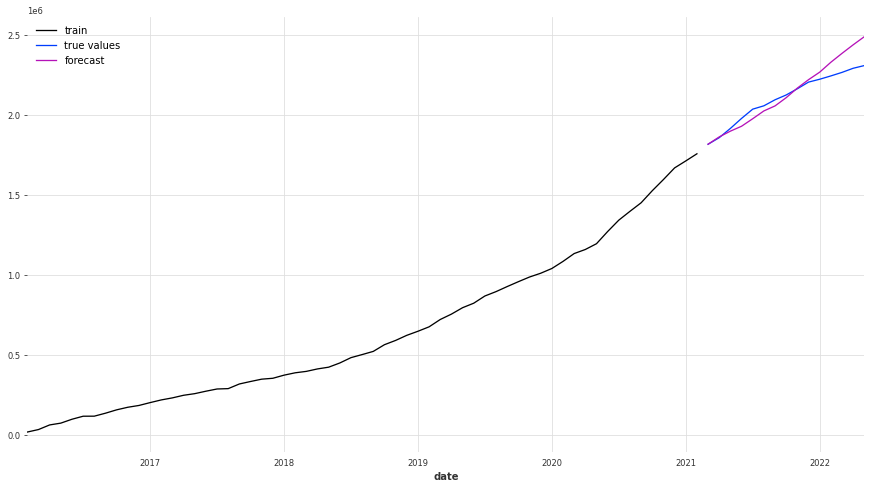

In [83]:
series_to_show = 'y3'

fig, ax = plt.subplots(figsize = (15, 8))
train[series_to_show].plot(label = 'train')
test[series_to_show].plot(label = 'true values')
rnn_forecast_db[series_to_show].plot(label = 'forecast')
plt.legend();

In [84]:
mape_rnn = evaluate_mape(test, rnn_forecast_db)
mape_rnn

{'mape_avg': 2.580028073616867,
 'mape_p25': 1.1905499754556461,
 'mape_p50': 2.3961146976260665,
 'mape_p75': 3.8252075272581365,
 'mape_p95': 5.431237970521701,
 'mape_p99': 6.2666093604872835,
 'mape_w1_avg': 0.6268436948680496,
 'mape_w1_p75': 0.8654181241923911,
 'mape_w2_avg': 1.683488952135272,
 'mape_w2_p75': 2.3222247802051834,
 'mape_w3_avg': 2.6338919612851526,
 'mape_w3_p75': 3.322081103853216,
 'mape_w4_avg': 3.3987754133940262,
 'mape_w4_p75': 5.318640037823343,
 'mape_w5_avg': 4.557140346401835,
 'mape_w5_p75': 6.643929497610401}

In [108]:
# Serie diferenciada + escalada - 25 series - 12/25/1/100
# mape_rnn = evaluate_mape(test, rnn_forecast)
# mape_rnn

{'mape_avg': 2.8736191677615937,
 'mape_p25': 1.495642895045998,
 'mape_p50': 2.5849186682023984,
 'mape_p75': 4.311232393969427,
 'mape_p95': 4.72777296382574,
 'mape_p99': 6.396665094875381,
 'mape_w1_avg': 0.8070515379057105,
 'mape_w1_p75': 0.9593624973564768,
 'mape_w2_avg': 1.981140715314838,
 'mape_w2_p75': 2.7017346174531482,
 'mape_w3_avg': 2.9349188238432706,
 'mape_w3_p75': 4.021062452506911,
 'mape_w4_avg': 3.8313464230198697,
 'mape_w4_p75': 5.901333187345272,
 'mape_w5_avg': 4.813638338724282,
 'mape_w5_p75': 6.677981248741543}

In [116]:
# Serie diferenciada + escalada - 25 series - 12/25/2/100
# mape_rnn = evaluate_mape(test, rnn_forecast)
# mape_rnn

{'mape_avg': 3.0112018392959796,
 'mape_p25': 1.6346648911944508,
 'mape_p50': 2.643531902224727,
 'mape_p75': 4.384749560910158,
 'mape_p95': 5.7119808070082945,
 'mape_p99': 6.461117555731976,
 'mape_w1_avg': 0.8544656989351715,
 'mape_w1_p75': 1.0788590923711638,
 'mape_w2_avg': 2.0597950885714345,
 'mape_w2_p75': 2.7605200981794504,
 'mape_w3_avg': 3.072297468199113,
 'mape_w3_p75': 4.033460023304478,
 'mape_w4_avg': 4.012775164623019,
 'mape_w4_p75': 5.79662329889207,
 'mape_w5_avg': 5.0566757761511605,
 'mape_w5_p75': 7.156910534753062}

In [123]:
# Serie diferenciada + escalada - 25 series - 12/25/4/100
# mape_rnn = evaluate_mape(test, rnn_forecast)
# mape_rnn

{'mape_avg': 2.9717198558940363,
 'mape_p25': 1.9031734984356499,
 'mape_p50': 2.180100282471181,
 'mape_p75': 3.1286864160523438,
 'mape_p95': 6.165214448562615,
 'mape_p99': 6.545890968583246,
 'mape_w1_avg': 0.7280268152441519,
 'mape_w1_p75': 0.9490412161673006,
 'mape_w2_avg': 2.037128487402374,
 'mape_w2_p75': 2.7331815115383207,
 'mape_w3_avg': 3.0115379480046096,
 'mape_w3_p75': 4.557181873193076,
 'mape_w4_avg': 3.8942837473114333,
 'mape_w4_p75': 4.569694854141091,
 'mape_w5_avg': 5.187622281507609,
 'mape_w5_p75': 6.177137241425437}

### NO --- Un modelo para cada serie

## Prueba con LSTM

### Diferenciación  + escalado

In [85]:
train_diff = train.diff()
train_diff.iloc[0, :] = train.iloc[0, :].copy()
train_diff

component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25
date,,,,,,,,,,,,,,,,,,,,,
2016-02-01,1415.50,761.90,18071.57,4556.15,827.79,213.36,1787.67,156.47,171.18,945.30,...,1016.69,491.90,2929.29,1067.31,3626.05,1874.63,1417.32,1579.17,750.69,1450.28
2016-03-01,703.65,1566.38,15538.54,5242.45,1925.56,170.90,1920.65,2145.67,227.64,632.56,...,1036.85,501.34,3212.85,850.85,3109.44,4826.24,1947.79,2027.96,2504.46,358.54
2016-04-01,854.47,2102.00,28847.08,5164.56,1465.35,172.26,2051.29,490.71,276.58,661.02,...,1006.09,632.91,3546.42,957.71,9009.18,1795.18,1428.01,1898.38,1649.49,1440.87
2016-05-01,1522.87,805.14,11277.05,2695.05,1422.99,258.78,2650.71,346.87,173.26,775.00,...,1023.38,168.22,4186.94,850.41,4183.75,2038.51,2896.45,1245.68,2436.54,1076.46
2016-06-01,1264.18,1704.45,24274.20,1534.24,784.30,209.10,2246.53,118.64,272.03,510.50,...,784.61,498.36,4574.51,968.59,6180.16,1567.19,1191.19,1790.07,3669.24,910.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,4386.25,2744.17,75513.67,41959.36,8868.02,1363.38,4059.19,2233.60,809.64,1847.35,...,2849.83,2178.00,12431.67,411.76,93385.67,35536.15,5859.75,13901.77,5857.53,3984.66
2020-11-01,4814.00,2471.20,69815.36,35310.72,8267.46,1330.61,4049.59,2236.32,1003.60,1458.88,...,2618.01,1849.46,19653.89,1016.20,98362.45,44477.21,6130.54,18014.33,7502.40,3923.27
2020-12-01,4446.79,3456.40,72743.34,32468.92,8083.89,1017.35,3222.86,2099.16,907.59,1597.98,...,2601.93,1863.77,21728.70,790.49,92214.31,23150.86,5177.19,12501.61,6412.66,3464.26


In [86]:
scaler = Scaler()
train_all_diff = [TimeSeries.from_dataframe(train_diff.loc[:, [f'y{i}']]) for i in range (1, len(train_diff.columns) + 1)]
train_all_diff_scaled = scaler.fit_transform(train_all_diff)

In [87]:
lstm_model = RNNModel(input_chunk_length = 12,
                     model = 'LSTM',
                     hidden_dim = 25,
                     n_rnn_layers = 6,
                     n_epochs = 100,
                     random_state = 123)

In [88]:
%%time

lstm_model.fit(train_all_diff_scaled)

[2022-07-15 08:57:28,764] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 925 samples.
[2022-07-15 08:57:28,764] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 925 samples.
2022-07-15 08:57:28 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 925 samples.
[2022-07-15 08:57:28,775] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-07-15 08:57:28,775] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-07-15 08:57:28 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-07-15 08:57:28 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-07-15 08:57:28 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-07-15 08:57:28 pytorch_l

Training: 0it [00:00, ?it/s]

CPU times: user 9min 22s, sys: 3.73 s, total: 9min 26s
Wall time: 3min


In [89]:
%%time

lstm_forecast = lstm_model.predict(len(test), series = train_all_diff_scaled)
lstm_forecast

Predicting: 29it [00:00, ?it/s]

CPU times: user 300 ms, sys: 4.2 ms, total: 304 ms
Wall time: 164 ms


[<TimeSeries (DataArray) (date: 15, component: 1, sample: 1)>
 array([[[0.66395607]],
 
        [[0.61463151]],
 
        [[0.41870711]],
 
        [[0.30728822]],
 
        [[0.33672359]],
 
        [[0.28285558]],
 
        [[0.28344778]],
 
        [[0.25937368]],
 
        [[0.29522612]],
 
        [[0.34657701]],
 
        [[0.34530301]],
 
        [[0.38570557]],
 
        [[0.47300287]],
 
        [[0.60598014]],
 
        [[0.55138917]]])
 Coordinates:
   * date       (date) datetime64[ns] 2021-03-01 2021-04-01 ... 2022-05-01
   * component  (component) object 'y1'
 Dimensions without coordinates: sample,
 <TimeSeries (DataArray) (date: 15, component: 1, sample: 1)>
 array([[[0.50951384]],
 
        [[0.3692706 ]],
 
        [[0.28764367]],
 
        [[0.27510482]],
 
        [[0.37379158]],
 
        [[0.36932224]],
 
        [[0.2611025 ]],
 
        [[0.27235543]],
 
        [[0.41126107]],
 
        [[0.56283012]],
 
        [[0.53487727]],
 
        [[0.54966556]],
 
     

In [90]:
# scale back
lstm_forecast = scaler.inverse_transform(lstm_forecast)

In [91]:
%%time 
lstm_forecast_dfs = [lstm_forecast[i].pd_dataframe() for i in range(len(lstm_forecast))]
lstm_forecast_s = pd.concat(lstm_forecast_dfs, axis = 1)

lstm_forecast = lstm_forecast_s.copy()
lstm_forecast.iloc[0, :] = lstm_forecast.iloc[0, :] + train.iloc[-1, :]
lstm_forecast = lstm_forecast.cumsum(axis = 0)
lstm_forecast

CPU times: user 12.9 ms, sys: 3.95 ms, total: 16.8 ms
Wall time: 15.1 ms


component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25
date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,124819.615639,120364.101205,1.803518e+06,9.664926e+05,236382.955324,41367.912420,154703.040487,94972.906458,34531.941109,59884.056739,...,108631.998697,73499.673057,484431.415237,53097.795142,1.999776e+06,9.278328e+05,237936.517548,353558.328334,305575.413182,113311.225916
2021-04-01,127781.927734,121938.278534,1.844025e+06,9.906776e+05,243131.853303,42360.401344,156224.576664,96607.949006,35199.330296,60780.458889,...,110630.869768,75637.691218,495154.720612,53926.106500,2.084813e+06,9.478106e+05,242403.968559,363487.589987,310373.708035,115504.434662
2021-05-01,129802.827039,123268.864779,1.883206e+06,1.016447e+06,248995.424019,43366.246168,157666.392145,98248.614932,35836.257826,61577.266139,...,112584.216755,77551.620807,504611.378677,54958.773158,2.166828e+06,9.637917e+05,245791.940649,371330.925335,315073.582233,116987.334522
2021-06-01,131288.360783,124562.032588,1.927132e+06,1.044413e+06,254340.624859,44414.308241,158971.256586,99814.489272,36453.727973,62353.961053,...,114424.117305,79009.455976,513616.890786,55768.879302,2.253375e+06,9.807580e+05,249954.300362,380041.196925,320211.702106,117926.185946
2021-07-01,132915.330904,126149.701429,1.974203e+06,1.074515e+06,258783.494814,45473.760207,160536.019036,101344.684424,37197.735110,63139.045538,...,116295.770634,80590.954773,523497.299426,56434.006099,2.338208e+06,9.984835e+05,253699.142889,388410.106085,325988.670677,119052.476911
2021-08-01,134283.466309,127724.032857,2.024281e+06,1.102728e+06,263197.658619,46532.119970,161878.604633,102811.342311,37968.768500,63993.935003,...,118316.979941,82130.032688,534776.035010,57326.805961,2.409488e+06,1.015836e+06,257411.435932,398576.929074,331302.114713,120474.574406
2021-09-01,135654.447233,128975.414943,2.073945e+06,1.131530e+06,267648.688019,47599.270309,163238.423909,105069.402440,38621.121307,64904.937316,...,120203.264038,83517.080071,543193.455505,58423.790468,2.470951e+06,1.032269e+06,261344.912026,408380.395295,335824.081872,121759.154554
2021-10-01,136909.752585,130260.378019,2.121654e+06,1.165393e+06,272339.787799,48689.094504,164902.013329,107831.434487,39428.941888,65821.000476,...,122183.804821,84980.634607,552448.617707,59352.564458,2.525755e+06,1.048852e+06,266275.972496,418234.445317,341398.237808,123272.559711
2021-11-01,138337.328187,131959.863304,2.169204e+06,1.199117e+06,277025.625853,49777.591552,166787.317509,109701.212224,40515.259766,66891.236456,...,124222.406831,86775.025681,564584.676897,60080.734047,2.581042e+06,1.066177e+06,271988.644736,429304.635603,347578.547012,125081.193630


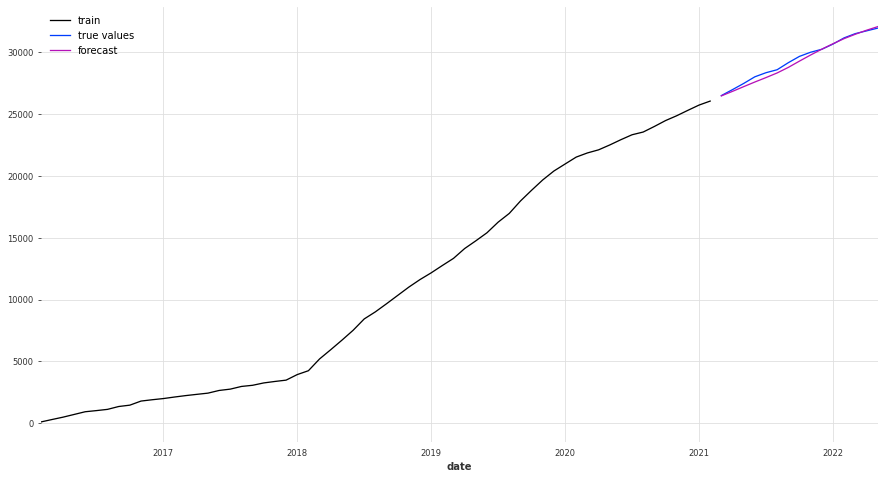

In [92]:
series_to_show = 'y12'

fig, ax = plt.subplots(figsize = (15, 8))
train[series_to_show].plot(label = 'train')
test[series_to_show].plot(label = 'true values')
lstm_forecast[series_to_show].plot(label = 'forecast')
plt.legend();

In [93]:
mape_lstm = evaluate_mape(test, lstm_forecast)
mape_lstm

{'mape_avg': 3.3082776418537265,
 'mape_p25': 1.3363761322637622,
 'mape_p50': 2.9510326077038456,
 'mape_p75': 4.192763941746318,
 'mape_p95': 7.6873902357817085,
 'mape_p99': 9.120397129236014,
 'mape_w1_avg': 0.9892103212944849,
 'mape_w1_p75': 1.264564024135448,
 'mape_w2_avg': 2.273687079807766,
 'mape_w2_p75': 2.9876668010220264,
 'mape_w3_avg': 3.3684315124429065,
 'mape_w3_p75': 4.6597016926181825,
 'mape_w4_avg': 4.402981405750121,
 'mape_w4_p75': 6.00842926314627,
 'mape_w5_avg': 5.507077889973351,
 'mape_w5_p75': 7.178499423188323}

___________________

## Prueba con Prophet

In [94]:
%%time

prophet_models = {}

for i in range(1, len(train.columns) + 1):
    prophet_model = Prophet(seasonality_mode = 'multiplicative',
                        seasonality_prior_scale = 10,
                        changepoint_prior_scale = 0.05,
                           changepoint_range = 0.85)
    prophet_model.fit(TimeSeries.from_dataframe(train.loc[:, [f'y{i}']]))
    prophet_models[f'y{i}'] = prophet_model

2022-07-15 09:00:32 prophet INFO: Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-07-15 09:00:32 prophet INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
2022-07-15 09:00:33 prophet INFO: Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-07-15 09:00:33 prophet INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

2022-07-15 09:00:51 prophet INFO: Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-07-15 09:00:51 prophet INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
2022-07-15 09:00:53 prophet INFO: Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-07-15 09:00:53 prophet INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

CPU times: user 29.7 s, sys: 1.63 s, total: 31.3 s
Wall time: 32.6 s


In [95]:
%%time

prophet_forecasts = {}

for k in prophet_models.keys():
    prophet_forecasts[k] = prophet_models[k].predict(len(test))

/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprec

/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprec

CPU times: user 33.2 s, sys: 96.6 ms, total: 33.3 s
Wall time: 33.5 s


In [96]:
%%time 
prophet_forecast_dfs = [prophet_forecasts[k].pd_dataframe() for k in prophet_forecasts.keys()]
prophet_forecast = pd.concat(prophet_forecast_dfs, axis = 1)
prophet_forecast

CPU times: user 7.65 ms, sys: 3.94 ms, total: 11.6 ms
Wall time: 10.8 ms


component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25
date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,125122.881206,121322.222270,1.873651e+06,9.868314e+05,239283.881506,42344.167253,155338.901233,94163.082555,35197.297346,61519.841369,...,107866.234874,71939.492072,481747.900531,54409.207485,1.959962e+06,9.266786e+05,236445.348851,356702.675650,308732.192475,115265.876962
2021-04-01,127692.383494,122381.354770,1.929179e+06,1.027104e+06,248299.606303,43623.817602,157673.047885,96231.324117,35872.412993,62637.746016,...,109621.609504,73122.447308,492436.538463,54870.911714,2.010751e+06,9.535623e+05,239235.998136,365881.084441,314162.349344,118477.603244
2021-05-01,130933.153950,125778.240422,1.963338e+06,1.055730e+06,253792.962761,45123.267005,160134.773737,97443.940804,36590.689645,63919.262857,...,111430.106891,74015.057099,499864.232547,55707.608311,2.045102e+06,9.847871e+05,243283.258546,373101.211154,322597.175194,120476.337573
2021-06-01,133604.116579,128625.502220,2.036760e+06,1.098724e+06,260138.406976,46050.948975,162395.877045,99167.398189,37387.950509,64934.570069,...,113571.921626,75046.308588,509793.029559,57052.116262,2.071468e+06,1.036055e+06,247650.981189,383609.189444,330673.891366,122839.975445
2021-07-01,137084.467830,131910.441980,2.117206e+06,1.156568e+06,268424.324916,47559.027359,166290.158117,101740.440947,38255.352269,66925.834976,...,116517.731710,76646.530918,529814.234771,57695.972440,2.133771e+06,1.069486e+06,252793.063712,402018.605964,339477.818248,126540.434588
2021-08-01,138188.958679,133098.054468,2.160347e+06,1.195816e+06,272620.429159,48491.112009,167489.712914,103019.380042,38701.169563,67810.169330,...,118098.497866,76719.611823,539593.799146,57493.768908,2.169410e+06,1.095118e+06,255187.147917,414283.685098,345730.451669,127849.232437
2021-09-01,141941.307368,136087.235059,2.215176e+06,1.252682e+06,281222.333635,50157.896623,172351.992498,104524.077380,39145.313879,69529.748916,...,121167.058428,78514.321514,553013.966173,57563.761772,2.246865e+06,1.136177e+06,260280.086549,428256.563633,354187.824736,131595.539752
2021-10-01,146419.438108,138885.725460,2.296214e+06,1.293489e+06,290185.193060,51512.484053,176584.247004,106217.645598,39909.114091,71326.760282,...,123964.125130,80957.177018,567264.806268,58089.971219,2.346531e+06,1.180242e+06,266448.745279,443516.801694,360568.443171,135900.964633
2021-11-01,152187.088590,141829.191553,2.363512e+06,1.329956e+06,299265.799789,52598.989924,181092.692579,108844.414698,41119.382159,72812.354259,...,126669.849336,82918.310226,591739.670904,58884.399266,2.466004e+06,1.224731e+06,273041.594351,461433.630297,367734.060335,139640.086680


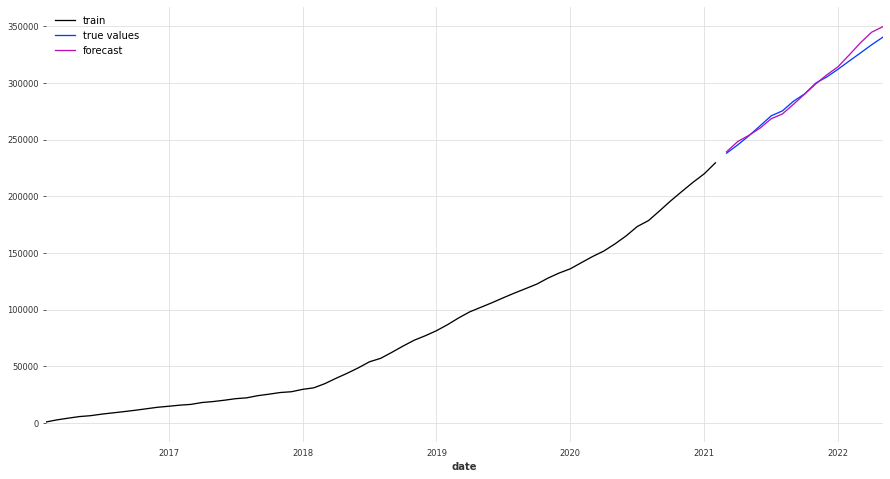

In [97]:
series_to_show = 'y5'

fig, ax = plt.subplots(figsize = (15, 8))
train[series_to_show].plot(label = 'train')
test[series_to_show].plot(label = 'true values')
prophet_forecast[series_to_show].plot(label = 'forecast')
plt.legend();

In [98]:
mape_prophet = evaluate_mape(test, prophet_forecast)
mape_prophet

{'mape_avg': 4.733657533390446,
 'mape_p25': 1.9622940645606997,
 'mape_p50': 3.3348267007084975,
 'mape_p75': 7.9411926819871175,
 'mape_p95': 10.525382170654073,
 'mape_p99': 10.720506232776607,
 'mape_w1_avg': 2.0637427976493274,
 'mape_w1_p75': 2.8331517105902986,
 'mape_w2_avg': 3.7558929423068106,
 'mape_w2_p75': 4.555766995810661,
 'mape_w3_avg': 5.071343465061946,
 'mape_w3_p75': 7.573598842458949,
 'mape_w4_avg': 5.6047833698166745,
 'mape_w4_p75': 9.15385030818077,
 'mape_w5_avg': 7.172525092117464,
 'mape_w5_p75': 10.23359860030889}

__________________

## Prueba con ARIMA

In [99]:
%%time

arima_models = {}

for i in range(1, len(train.columns) + 1):
    arima_model = ARIMA(p = 12,
                        d = 1,
                        q = 1,
                        seasonal_order = [0, 0, 0, 0],
                        trend = 'n',
                        random_state = 123)
    arima_model.fit(TimeSeries.from_dataframe(train.loc[:, [f'y{i}']]))
    arima_models[f'y{i}'] = arima_model

/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization fai

/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization fai

CPU times: user 37.1 s, sys: 18.8 s, total: 55.9 s
Wall time: 14.5 s


/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [100]:
%%time

arima_forecasts = {}

for k in arima_models.keys():
    arima_forecasts[k] = arima_models[k].predict(len(test))

CPU times: user 190 ms, sys: 98.5 ms, total: 289 ms
Wall time: 103 ms


In [101]:
arima_forecast_dfs = [arima_forecasts[k].pd_dataframe() for k in arima_forecasts.keys()]
arima_forecast = pd.concat(arima_forecast_dfs, axis = 1)
arima_forecast

component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25
date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,125790.009134,120526.954468,1.819058e+06,9.801427e+05,237977.792410,41598.896282,155284.133105,95196.659595,34484.581723,59741.712829,...,109237.869399,74409.904797,480874.661512,53353.243653,2.030678e+06,9.211182e+05,236831.705109,351743.001809,305322.948352,111802.406053
2021-04-01,129386.560863,122963.115371,1.871578e+06,1.019471e+06,246411.193827,42642.068564,157616.052070,96613.353264,35143.900621,60741.093888,...,111661.087701,76442.726167,494378.653020,54075.442154,2.125420e+06,9.431921e+05,241185.947853,360551.757008,309894.193382,112875.799043
2021-05-01,133741.616234,124625.684675,1.909537e+06,1.063628e+06,255294.827027,43827.412502,160038.349883,97848.992048,35581.739386,62001.206520,...,114254.340958,78643.700245,510051.085937,54942.968952,2.227867e+06,9.622365e+05,246166.944472,367468.752226,315755.268065,114278.711642
2021-06-01,136705.204838,126821.958065,1.944132e+06,1.103834e+06,264049.185903,44868.823546,162047.543495,99472.994361,35968.116187,62987.138957,...,116644.054700,80653.475957,516882.607433,55802.095277,2.331420e+06,9.911810e+05,251476.621326,374758.381445,321013.127542,114656.255360
2021-07-01,140222.454607,128649.278229,1.988506e+06,1.146978e+06,273080.921331,46101.174260,164505.533825,101181.191734,36528.068769,64266.180130,...,119546.466323,82963.086307,532275.383255,56511.728288,2.441084e+06,1.014928e+06,256394.501826,384501.079345,326858.057428,115651.220896
2021-08-01,143422.885042,130450.921730,2.034965e+06,1.184442e+06,281376.256017,47150.682202,166475.084351,102841.667892,37162.139284,65140.518852,...,122110.664570,84920.827150,547154.827573,56895.821266,2.541051e+06,1.032191e+06,260611.537648,395115.158001,333392.157252,116251.003355
2021-09-01,146666.247310,132738.065553,2.081787e+06,1.224908e+06,290561.621836,48327.346599,169714.698479,104480.501836,37726.941277,66357.410430,...,124322.809138,86930.547559,558156.151357,57431.905324,2.641872e+06,1.058217e+06,265312.284213,406614.585864,339209.430512,117936.489000
2021-10-01,150662.309084,135364.927247,2.121621e+06,1.263946e+06,299295.925601,49351.909148,172504.360739,106234.811936,38230.275727,67651.000544,...,127104.247818,88887.471608,570300.510817,57992.808062,2.748567e+06,1.080427e+06,270086.408466,418383.323284,345613.749287,120023.113022
2021-11-01,154352.232311,137443.623015,2.165131e+06,1.303566e+06,308218.315566,50530.780779,175856.544215,108058.398225,38789.647161,68870.028564,...,129551.476549,90802.656501,584882.874287,58771.518550,2.853501e+06,1.108653e+06,275235.787111,432120.372197,351525.098657,121869.228827


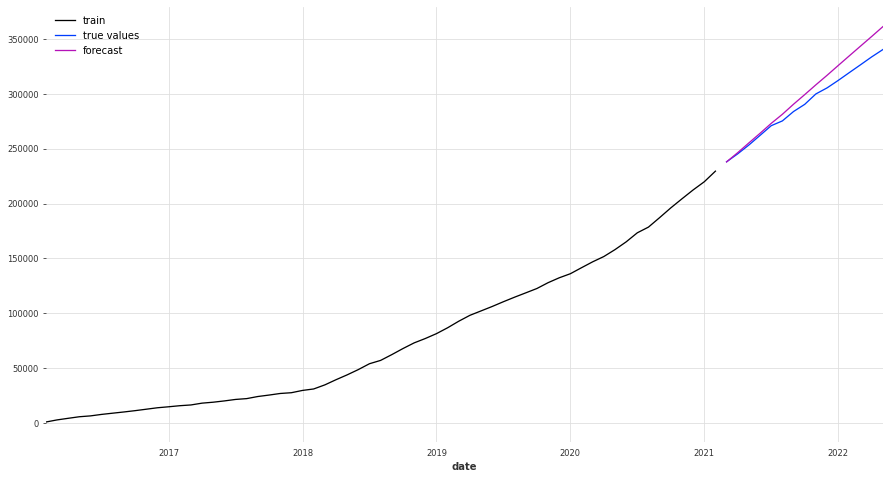

In [102]:
series_to_show = 'y5'

fig, ax = plt.subplots(figsize = (15, 8))
train[series_to_show].plot(label = 'train')
test[series_to_show].plot(label = 'true values')
arima_forecast[series_to_show].plot(label = 'forecast')
plt.legend();

In [103]:
mape_arima = evaluate_mape(test, arima_forecast)
mape_arima

{'mape_avg': 3.1571967512771244,
 'mape_p25': 1.8898974170644756,
 'mape_p50': 2.860511616413161,
 'mape_p75': 3.938268161811888,
 'mape_p95': 5.521177560756635,
 'mape_p99': 8.831314287836332,
 'mape_w1_avg': 0.8727948237254337,
 'mape_w1_p75': 1.173239066380537,
 'mape_w2_avg': 2.0291167234783756,
 'mape_w2_p75': 2.170700733850442,
 'mape_w3_avg': 2.971936660549724,
 'mape_w3_p75': 4.043361347519689,
 'mape_w4_avg': 4.171010931169658,
 'mape_w4_p75': 5.890714366160759,
 'mape_w5_avg': 5.7411246174624315,
 'mape_w5_p75': 6.9989467871413895}

### Prueba con p, d, q = 1, 2, 1

In [117]:
%%time

arima_models = {}

for i in range(1, len(train.columns) + 1):
    arima_model = ARIMA(p = 1,
                        d = 2,
                        q = 1,
                        seasonal_order = [0, 0, 0, 0],
                        trend = 'n',
                        random_state = 123)
    arima_model.fit(TimeSeries.from_dataframe(train.loc[:, [f'y{i}']]))
    arima_models[f'y{i}'] = arima_model

/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/sgrodriguez/miniconda3/envs/kedro_timeseries/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters 

CPU times: user 1.56 s, sys: 418 ms, total: 1.98 s
Wall time: 997 ms


In [118]:
%%time

arima_forecasts = {}

for k in arima_models.keys():
    arima_forecasts[k] = arima_models[k].predict(len(test))

CPU times: user 89.2 ms, sys: 497 µs, total: 89.7 ms
Wall time: 88.4 ms


In [119]:
arima_forecast_dfs = [arima_forecasts[k].pd_dataframe() for k in arima_forecasts.keys()]
arima_forecast_121 = pd.concat(arima_forecast_dfs, axis = 1)
arima_forecast_121

component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25
date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,125332.801890,120591.330397,1.810838e+06,9.778732e+05,238281.956383,41499.943640,155105.179985,95263.851006,34340.128944,59843.949271,...,108790.125445,74324.887069,477738.055038,53471.305484,2.025110e+06,9.300887e+05,236598.482915,350514.347937,304782.265070,112278.032532
2021-04-01,129040.223267,122678.270537,1.864921e+06,1.015768e+06,247103.008141,42634.824572,158044.517100,97074.077226,34936.897558,61116.880265,...,111466.072027,76501.427537,490179.177574,54251.409839,2.128020e+06,9.527518e+05,241510.573228,359917.364638,309773.101423,114295.217563
2021-05-01,132747.513665,124792.824690,1.919087e+06,1.053496e+06,255917.512771,43775.216779,160986.878556,98893.724420,35551.578091,62390.894160,...,114041.179993,78676.362097,502691.330017,55040.632760,2.230893e+06,9.745624e+05,246423.475705,369605.667988,314616.214081,116313.075986
2021-06-01,136454.800688,126901.644655,1.973262e+06,1.091270e+06,264732.562442,44914.075148,163929.023845,100716.192341,36173.328680,63664.964240,...,116653.432741,80851.399024,515213.514818,55832.783551,2.333769e+06,9.956058e+05,251336.214613,379477.200809,319523.950665,118330.961235
2021-07-01,140162.087623,129011.655354,2.027437e+06,1.129032e+06,273547.566739,46053.360397,166871.184585,102539.504812,36797.869909,64939.037235,...,119252.002885,83026.429425,527737.116602,56625.874448,2.436645e+06,1.015959e+06,256248.986463,389466.415405,324403.416551,120348.847554
2021-08-01,143869.374556,131121.418790,2.081613e+06,1.166797e+06,282362.574813,47192.526842,169813.344220,104363.070150,37423.512637,66213.110381,...,121855.613136,85201.460242,540260.918523,57419.267205,2.539521e+06,1.035690e+06,261161.751678,399531.212820,329295.249875,122366.733915
2021-09-01,147576.661489,133231.233572,2.135789e+06,1.204561e+06,291177.582572,48331.726352,172755.503934,106186.711199,38049.590141,67487.183535,...,124457.366820,87376.491033,552784.748712,58212.756884,2.642396e+06,1.054862e+06,266074.518230,409644.554392,334181.672879,124384.620278
2021-10-01,151283.948421,135341.037691,2.189964e+06,1.242325e+06,299992.590358,49470.916659,175697.663643,108010.374916,38675.839257,68761.256690,...,127059.804386,89551.521825,565308.582893,59006.277684,2.745272e+06,1.073530e+06,270987.284513,419789.074151,339070.462708,126402.506641
2021-11-01,154991.235354,137450.844025,2.244140e+06,1.280089e+06,308807.598142,50610.109527,178639.823352,109834.045420,39302.156110,70035.329845,...,129661.990038,91726.552617,577832.417638,59799.808477,2.848148e+06,1.091745e+06,275900.050850,429953.618550,343958.217134,128420.393004


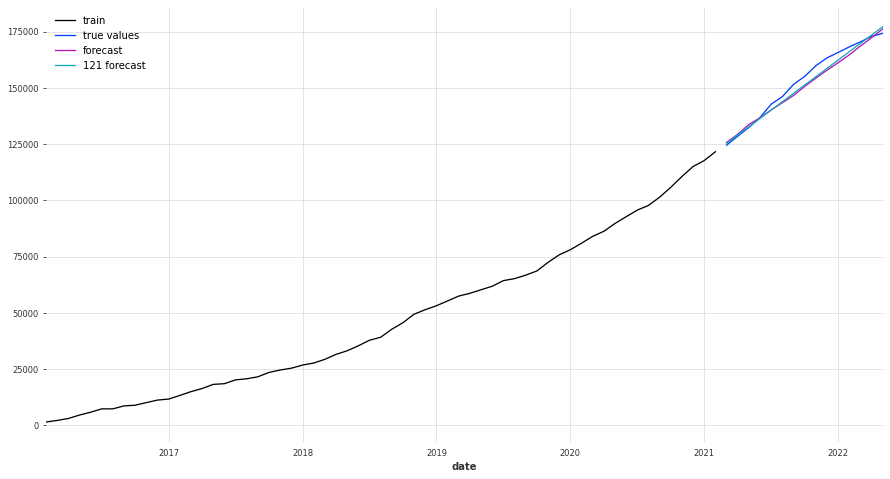

In [122]:
series_to_show = 'y1'

fig, ax = plt.subplots(figsize = (15, 8))
train[series_to_show].plot(label = 'train')
test[series_to_show].plot(label = 'true values')
arima_forecast[series_to_show].plot(label = 'forecast')
arima_forecast_121[series_to_show].plot(label = '121 forecast')
plt.legend();

In [121]:
mape_arima_121 = evaluate_mape(test, arima_forecast_121)
mape_arima_121

{'mape_avg': 2.760212174446811,
 'mape_p25': 1.339159064773989,
 'mape_p50': 1.9277482680850346,
 'mape_p75': 3.708066638101463,
 'mape_p95': 6.2818542894876,
 'mape_p99': 7.758729776868132,
 'mape_w1_avg': 0.7649534452789618,
 'mape_w1_p75': 1.1505987452527906,
 'mape_w2_avg': 1.7495708970116801,
 'mape_w2_p75': 2.4983127374224914,
 'mape_w3_avg': 2.611200466128431,
 'mape_w3_p75': 3.6385900529586443,
 'mape_w4_avg': 3.547783924272785,
 'mape_w4_p75': 4.856388236223665,
 'mape_w5_avg': 5.127552139542197,
 'mape_w5_p75': 7.646700012511896}

## Prueba AutoARIMA

In [104]:
%%time

autoarima_models = {}

for i in range(1, len(train.columns) + 1):
    autoarima_model = AutoARIMA(start_p = 1,
                                start_q = 1,
                                max_p = 12,
                                max_q = 12,
                                max_order = None,
                                m = 12,
                                random_state = 123)
    autoarima_model.fit(TimeSeries.from_dataframe(train.loc[:, [f'y{i}']]))
    autoarima_models[f'y{i}'] = autoarima_model

CPU times: user 2min 45s, sys: 1min 22s, total: 4min 7s
Wall time: 1min 4s


In [105]:
for k in autoarima_models.keys():
    print(f'Values of (p, d, q): {autoarima_models[k].model.model_.order}')
    print(f'Values of (P, D, Q, m): {autoarima_models[k].model.model_.seasonal_order}')
    print('\n')

Values of (p, d, q): (0, 2, 1)
Values of (P, D, Q, m): (0, 0, 2, 12)


Values of (p, d, q): (1, 2, 2)
Values of (P, D, Q, m): (0, 0, 0, 12)


Values of (p, d, q): (0, 2, 1)
Values of (P, D, Q, m): (0, 0, 0, 12)


Values of (p, d, q): (1, 2, 0)
Values of (P, D, Q, m): (2, 0, 0, 12)


Values of (p, d, q): (0, 2, 1)
Values of (P, D, Q, m): (0, 0, 0, 12)


Values of (p, d, q): (1, 2, 1)
Values of (P, D, Q, m): (0, 0, 0, 12)


Values of (p, d, q): (0, 2, 1)
Values of (P, D, Q, m): (2, 0, 0, 12)


Values of (p, d, q): (0, 2, 1)
Values of (P, D, Q, m): (0, 0, 0, 12)


Values of (p, d, q): (0, 2, 2)
Values of (P, D, Q, m): (0, 0, 0, 12)


Values of (p, d, q): (1, 2, 1)
Values of (P, D, Q, m): (0, 0, 2, 12)


Values of (p, d, q): (0, 2, 1)
Values of (P, D, Q, m): (2, 0, 0, 12)


Values of (p, d, q): (1, 2, 0)
Values of (P, D, Q, m): (0, 0, 0, 12)


Values of (p, d, q): (2, 2, 1)
Values of (P, D, Q, m): (0, 0, 1, 12)


Values of (p, d, q): (0, 2, 1)
Values of (P, D, Q, m): (1, 0, 0, 12)


Values

In [106]:
%%time

autoarima_forecasts = {}

for k in autoarima_models.keys():
    autoarima_forecasts[k] = autoarima_models[k].predict(len(test))

CPU times: user 161 ms, sys: 20.2 ms, total: 181 ms
Wall time: 157 ms


In [107]:
autoarima_forecast_dfs = [autoarima_forecasts[k].pd_dataframe() for k in autoarima_forecasts.keys()]
autoarima_forecast = pd.concat(autoarima_forecast_dfs, axis = 1)
autoarima_forecast

component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25
date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,125296.606742,120445.376270,1.811315e+06,9.811013e+05,238503.325090,41499.943640,154806.141898,95276.750380,34340.625880,59805.858811,...,108970.442421,74341.728037,479267.848846,53476.352816,2.023255e+06,9.320578e+05,236646.377011,351383.967577,304694.442871,112240.414219
2021-04-01,128516.602803,122619.086795,1.865028e+06,1.019861e+06,247595.173709,42634.824572,157129.159008,97068.410760,34970.190969,60881.037981,...,111511.684300,76509.916074,492487.801811,54301.530752,2.121798e+06,9.578079e+05,241610.394021,359913.492628,309690.987083,114203.078439
2021-05-01,132167.310958,124698.903696,1.918740e+06,1.058655e+06,256815.095857,43775.216779,159659.122391,98860.071140,35599.756058,62215.719777,...,114065.187245,78678.104111,505560.070761,55026.896512,2.226061e+06,9.838976e+05,246574.411032,367780.099709,314471.249624,116165.742658
2021-06-01,135703.788994,126867.106766,1.972453e+06,1.097066e+06,266163.091534,44914.075148,162195.770264,100651.731520,36229.321147,63635.224792,...,116771.983722,80846.292148,519462.176175,55847.769601,2.326731e+06,1.014082e+06,251538.428043,377136.300577,319359.992061,118128.406878
2021-07-01,139371.859418,128952.108075,2.026166e+06,1.136014e+06,275639.160740,46053.360397,165173.181924,102443.391900,36858.886236,65163.948500,...,119585.017913,83014.480185,537136.060005,56620.345213,2.431607e+06,1.040786e+06,256502.445053,386809.393816,324194.324487,120091.071097
2021-08-01,142580.877659,131115.430836,2.079878e+06,1.174634e+06,285243.303475,47192.526842,167205.155268,104235.052280,37488.451325,66444.931762,...,122234.915466,85182.668223,551123.479260,57147.536512,2.533898e+06,1.067846e+06,261466.462064,396888.371768,329055.947217,122053.735317
2021-09-01,146069.543432,133205.026193,2.133591e+06,1.215988e+06,294975.519739,48331.726352,170841.939583,106026.712660,38118.016414,67702.953920,...,124934.491037,87350.856260,566369.981911,57694.958499,2.647069e+06,1.098508e+06,266430.479074,406426.580948,333903.882012,124016.399536
2021-10-01,149777.937226,135364.024376,2.187303e+06,1.253431e+06,304835.809532,49470.916659,174108.780467,107818.373040,38747.581502,69015.366610,...,127809.679572,89519.044297,581318.811340,58378.909752,2.767960e+06,1.129228e+06,271394.496085,416597.424223,338758.682233,125979.063756
2021-11-01,154041.554113,137457.690647,2.241016e+06,1.294511e+06,314824.172854,50610.109527,177621.792339,109610.033420,39377.146591,70127.990994,...,130666.140682,91687.232334,599480.623783,59263.441272,2.890968e+06,1.163560e+06,276358.513096,428015.402790,343610.038978,127941.727975


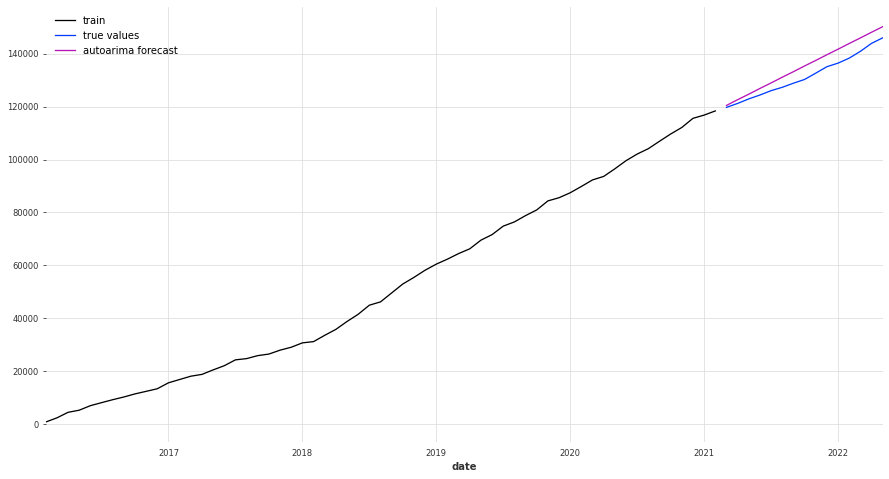

In [108]:
series_to_show = 'y2'

fig, ax = plt.subplots(figsize = (15, 8))
train[series_to_show].plot(label = 'train')
test[series_to_show].plot(label = 'true values')
autoarima_forecast[series_to_show].plot(label = 'autoarima forecast')
plt.legend();

In [109]:
mape_autoarima = evaluate_mape(test, autoarima_forecast)
mape_autoarima

{'mape_avg': 2.957326105133884,
 'mape_p25': 1.5743416092398903,
 'mape_p50': 2.349978544113882,
 'mape_p75': 3.8436560552282995,
 'mape_p95': 6.776413871223012,
 'mape_p99': 8.7978063717857,
 'mape_w1_avg': 0.7521006836990054,
 'mape_w1_p75': 1.1232226023467973,
 'mape_w2_avg': 1.7825879115549037,
 'mape_w2_p75': 2.4368967262300583,
 'mape_w3_avg': 2.77912739711587,
 'mape_w3_p75': 3.639412552319641,
 'mape_w4_avg': 3.9344891895842,
 'mape_w4_p75': 5.091300562091832,
 'mape_w5_avg': 5.538325343715444,
 'mape_w5_p75': 8.315912062767543}

## Prueba con Naive

In [110]:
%%time

naive_models = {}

for i in range(1, len(train.columns) + 1):
    naive_model = NaiveSeasonal(K = 1)
    naive_model.fit(TimeSeries.from_dataframe(train.loc[:, [f'y{i}']]))
    naive_models[f'y{i}'] = naive_model

CPU times: user 96.3 ms, sys: 34 µs, total: 96.3 ms
Wall time: 96.4 ms


In [111]:
%%time

naive_forecasts = {}

for k in naive_models.keys():
    naive_forecasts[k] = naive_models[k].predict(len(test))

CPU times: user 49 ms, sys: 0 ns, total: 49 ms
Wall time: 48 ms


In [112]:
%%time 
naive_forecast_dfs = [naive_forecasts[k].pd_dataframe() for k in naive_forecasts.keys()]
naive_forecast = pd.concat(naive_forecast_dfs, axis = 1)
naive_forecast

CPU times: user 11.6 ms, sys: 187 µs, total: 11.8 ms
Wall time: 11.2 ms


component,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25
date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,121620.3,118371.41,1757602.64,940583.52,229539.55,40345.26,152123.53,93485.09,33788.74,58591.89,...,106387.93,72173.54,465799.83,52719.6,1922702.66,906478.4,231682.36,341555.52,300129.11,110277.75
2021-04-01,121620.3,118371.41,1757602.64,940583.52,229539.55,40345.26,152123.53,93485.09,33788.74,58591.89,...,106387.93,72173.54,465799.83,52719.6,1922702.66,906478.4,231682.36,341555.52,300129.11,110277.75
2021-05-01,121620.3,118371.41,1757602.64,940583.52,229539.55,40345.26,152123.53,93485.09,33788.74,58591.89,...,106387.93,72173.54,465799.83,52719.6,1922702.66,906478.4,231682.36,341555.52,300129.11,110277.75
2021-06-01,121620.3,118371.41,1757602.64,940583.52,229539.55,40345.26,152123.53,93485.09,33788.74,58591.89,...,106387.93,72173.54,465799.83,52719.6,1922702.66,906478.4,231682.36,341555.52,300129.11,110277.75
2021-07-01,121620.3,118371.41,1757602.64,940583.52,229539.55,40345.26,152123.53,93485.09,33788.74,58591.89,...,106387.93,72173.54,465799.83,52719.6,1922702.66,906478.4,231682.36,341555.52,300129.11,110277.75
2021-08-01,121620.3,118371.41,1757602.64,940583.52,229539.55,40345.26,152123.53,93485.09,33788.74,58591.89,...,106387.93,72173.54,465799.83,52719.6,1922702.66,906478.4,231682.36,341555.52,300129.11,110277.75
2021-09-01,121620.3,118371.41,1757602.64,940583.52,229539.55,40345.26,152123.53,93485.09,33788.74,58591.89,...,106387.93,72173.54,465799.83,52719.6,1922702.66,906478.4,231682.36,341555.52,300129.11,110277.75
2021-10-01,121620.3,118371.41,1757602.64,940583.52,229539.55,40345.26,152123.53,93485.09,33788.74,58591.89,...,106387.93,72173.54,465799.83,52719.6,1922702.66,906478.4,231682.36,341555.52,300129.11,110277.75
2021-11-01,121620.3,118371.41,1757602.64,940583.52,229539.55,40345.26,152123.53,93485.09,33788.74,58591.89,...,106387.93,72173.54,465799.83,52719.6,1922702.66,906478.4,231682.36,341555.52,300129.11,110277.75


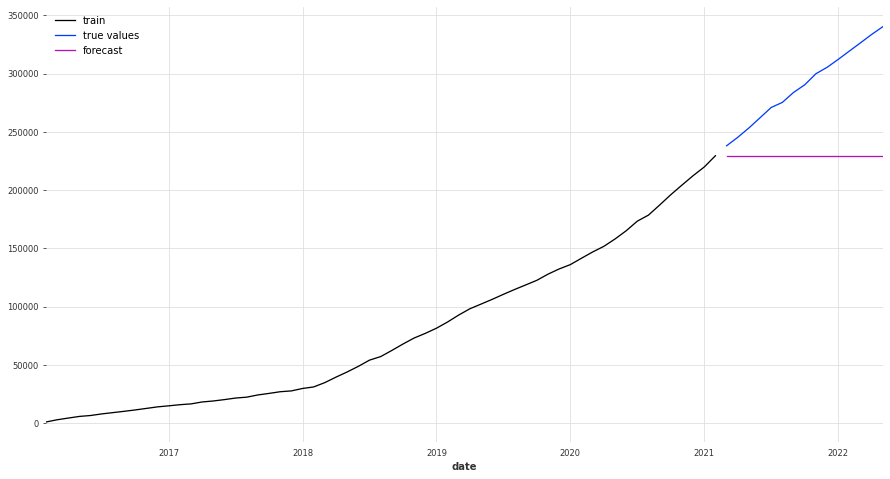

In [113]:
series_to_show = 'y5'

fig, ax = plt.subplots(figsize = (15, 8))
train[series_to_show].plot(label = 'train')
test[series_to_show].plot(label = 'true values')
naive_forecast[series_to_show].plot(label = 'forecast')
plt.legend();

In [114]:
mape_naive = evaluate_mape(test, naive_forecast)
mape_naive

{'mape_avg': 14.89007638504205,
 'mape_p25': 12.246723646299221,
 'mape_p50': 13.739411558319484,
 'mape_p75': 17.373489115911557,
 'mape_p95': 20.239461380619286,
 'mape_p99': 25.63005713364323,
 'mape_w1_avg': 4.463190114384614,
 'mape_w1_p75': 5.566321515984247,
 'mape_w2_avg': 10.512957692250795,
 'mape_w2_p75': 13.152821267015412,
 'mape_w3_avg': 15.70011689463465,
 'mape_w3_p75': 18.604826730182506,
 'mape_w4_avg': 20.171301248698096,
 'mape_w4_p75': 24.007835283139936,
 'mape_w5_avg': 23.6028159752421,
 'mape_w5_p75': 29.51699273397895}

## Comparativa gráfica de los modelos

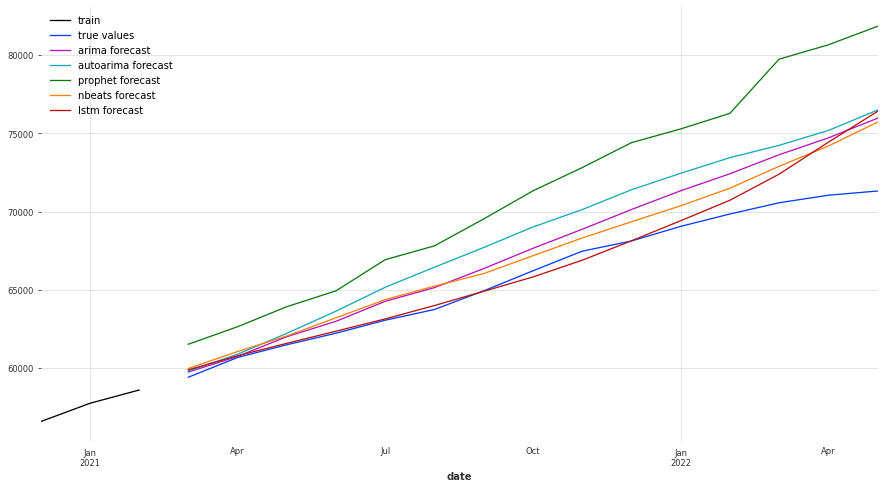

In [115]:
series_to_show = 'y10'

fig, ax = plt.subplots(figsize = (15, 8))
train[series_to_show][-3:].plot(label = 'train')
test[series_to_show].plot(label = 'true values')
#naive_forecast[series_to_show].plot(label = 'naive forecast')
arima_forecast[series_to_show].plot(label = 'arima forecast')
autoarima_forecast[series_to_show].plot(label = 'autoarima forecast')
prophet_forecast[series_to_show].plot(label = 'prophet forecast')
nbeats_forecast_db[series_to_show].plot(label = 'nbeats forecast')
#rnn_forecast[series_to_show].plot(label = 'rnn forecast')
lstm_forecast[series_to_show].plot(label = 'lstm forecast')
plt.legend();